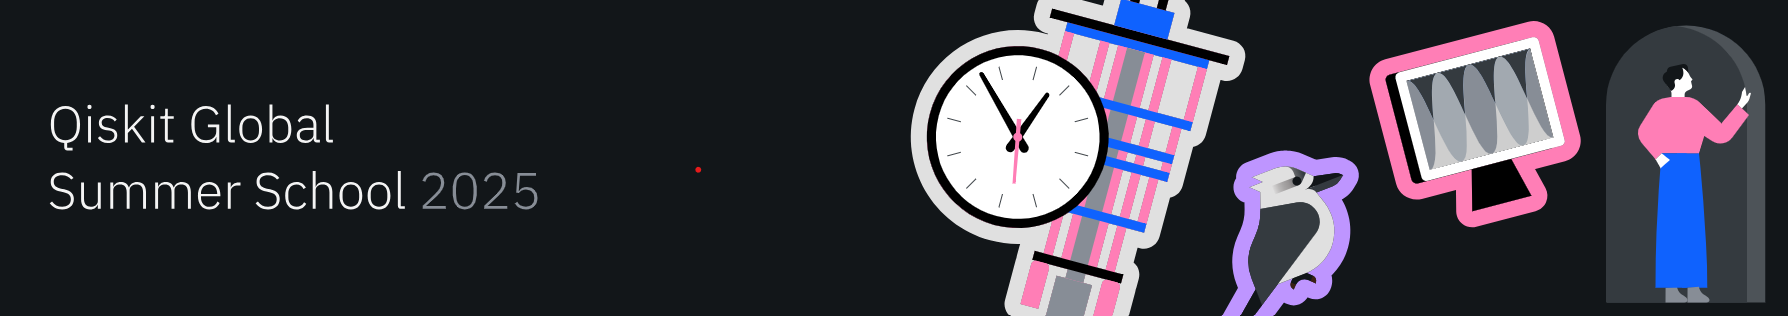

# Lab 2: Cutting through the noise

이번 랩에서는 양자 노이즈의 세계를 탐험하며 현대의 양자 컴퓨터에 발생하는 노이즈를 극복하고 원하는 데이터를 얻는 방법에 대해 알아보도록 하겠습니다. 작은 Max-cut 문제를 예시로 양자 컴퓨터에서 양자 알고리즘을 실행할 때에 노이즈를 어떻게 줄일 수 있는지 차근차근 배워봅시다. 양자 컴퓨터에 노이즈가 있더라도, 다양한 트랜스파일과 오차 완화 (Error Mitigation) 테크닉을 통해 오차를 최소화하고 올바른 결과를 얻을 수 있습니다. 랩의 마지막에는 랩에서 다룬 모든 테크닉들을 실제 양자 하드웨어에서 구현해보는 보너스 챌린지가 있습니다.

# 목차

0. [요구사항](#requirements)
1. [서론](#intro)  
    - [이번 랩의 목표](#spirit)
    - [양자 노이즈란?](#quantum-noise)  
    - [노이즈의 원인과 지표](#sources)
        * [연습문제 1: T1, T2, 게이트 충실도가 높고 측정 오류는 낮은 큐빗 찾아보기](#exercise_1)
2. [Max-cut 문제](#max-cut)
    - [문제: 그래프 정의하기](#the-graph)
    - [정의: 양자컴퓨터로 그래프 옮기기](#the-mapping)
        * [연습문제 2: Max-cut 문제를 Ising 해밀토니안으로 대응시키기](#exercise_2)
    - [QAOA 알고리즘](#qaoa-solution)
    - [해 확인하기](#checking)
3. [양자 노이즈 시뮬레이터](#noisy-simulator)
    - [백엔드 선택](#choosing-backend)
        * [연습문제 3: 오류율 예측](#exercise_3)
    - [NEAT를 이용한 오류율 예측](#neat)
4. [트랜스파일러](#transpiler)
    - [이중 큐빗 게이트의 수 최소화하기](#min-two-qubit)
    - [최적의 레이아웃 찾기](#opt-layout)
        * [연습문제 4: 모든 적합한 레이아웃 찾기](#exercise_4)
        * [연습문제 5: 트랜스파일러를 사용해 최선의 레이아웃 찾기](#exercise_5)
5. [오차 완화](#em)
    - [무잡음 추정법 (ZNE)](#zne)
        * [연습문제 6a: 양자 회로에서 전체적 접기 구현](#exercise_6a)
        * [연습문제 6b: 양자 회로에서 국소적 접기 구현](#exercise_6b)
6. [결론](#conclusions)
7. [보너스 챌린지: 더 키워보세요!](#bonus)

<a id="requirements"></a>

## 0. 요구사항

이 랩을 실행하는데 필요한 라이브러리는 다음과 같습니다:

* Qiskit SDK v2.0 with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime v0.22 or later (`pip install qiskit-ibm-runtime`)
* Rustworkx (`pip install rustworkx`)
* Qiskit Aer v0.17
* Pylatexenc


In [ ]:
# %pip install -U qiskit "qc-grader[qiskit,jupyter] @ git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git"

In [1]:
import qiskit
import qc_grader

print(f"Qiskit version: {qiskit.__version__}")
print(f"Grader version: {qc_grader.__version__}")

Qiskit version: 2.0.3
Grader version: 0.22.9


Qiskit 버전 `>=2.0.0` 그레이더 버전 `>=0.22.10` 이상이 설치되어 있어야 합니다. 만약 버전이 다르게 표시된다면 커널을 재시작해보시고, 그래도 안 된다면 그레이더를 다시 설치해야 할 수 있습니다.
랩 0에 따라 환경설정을 완료했는지, IBM Quantum 계정이 잘 저장되어 있는지 아래의 셀을 실행해 확인해주세요.

In [ ]:
# 계정이 잘 저장되어 있는지 확인합니다
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(name="dmridmrir")
service.saved_accounts()

In [3]:
backends = service.backends()
for backend in backends:
    print(backend.name)

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-07-13 08:23:23,527: Default instance not set. Searching all available instances.


# 불러오기

In [4]:
import rustworkx as rx
import numpy as np
import matplotlib.pyplot as plt
from rustworkx.visualization import mpl_draw as draw_graph
from qiskit_ibm_runtime import QiskitRuntimeService
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, Operator
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.transpiler import Layout

from qiskit_ibm_runtime import (
    Session,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions,
)
from qiskit_ibm_runtime.debug_tools import Neat
from qiskit_aer import AerSimulator

from utils import zne_method, plot_zne, plot_backend_errors_and_counts
from qc_grader.challenges.qgss_2025 import (
    grade_lab2_ex1,
    grade_lab2_ex2,
    grade_lab2_ex3,
    grade_lab2_ex4,
    grade_lab2_ex5,
    grade_lab2_ex6a,
    grade_lab2_ex6b,
)

## 1. 서론 <a id="intro"></a>

### 1.1 이번 랩의 목표 <a id="spirit"></a>

*이번 랩에서는 적절한 트랜스파일 및 오차 완화 기술을 통해 IBM Quantum 하드웨어의 성능을 십분 활용하여 실생활의 문제를 해결하는 방법을 알아봅니다.*

### 1.2 양자 노이즈란? <a id="quantum-noise"></a>

노이즈는 양자 컴퓨터를 만들고 사용하는 모든 과정의 중심이 되는 개념으로, 현대 양자 컴퓨터의 주요한 특성 중 하나입니다. 하지만 양자 정보에서 노이즈란 정확히 어떤 것을 의미할까요? 노이즈(에러, 오류, 오차)라 함은 주어진 양자 계산을 수행하여 측정하였을 때 예상되는 결과를 얻지 못하도록 방해하고 왜곡시키는 작용입니다. 우리는 이러한 노이즈를 크게 두 가지로 구분합니다:

- 결맞음(coherent) 오류: 이 종류의 노이즈는 결맞음을 해치지 않으면서 양자 계산 자체에서 발생하는 오류입니다. 주로 양자 게이트가 가해질 때에 존재하는 약간의 오차가 누적되어 발생하며, 이러한 오류는 정보를 파괴하지 않으므로, 이론상 원래 상태를 찾는 것도 가능합니다. 전형적인 예시로는 원래 각도 $\theta$ 만큼 큐빗을 회전시켜야 하는 게이트가 부정확한 조정 등으로 인해 실제로는 $\theta+\varepsilon$ 만큼 큐빗을 회전시키는 경우가 있습니다. Hadamard 게이트가 이런 식으로 잘못 조정되어 있다면 완벽한 중첩 상태를 만들지 못할 것이고, 결과에 편향성이 생길 수도 있겠죠.
- 결어긋남(incoherent) 오류: 이 종류의 노이즈는 양자적인 시스템이 주변 환경과 상호 작용을 하기 때문에 발생합니다. 이 종류의 오류 때문에, 우리는 대부분의 양자 컴퓨터를 mK 스케일의 극저온으로 냉각하여 주변 환경과의 상호 작용을 최소화하고 양자적인 결맞음 상태를 최대한 유지하려고 합니다. 이 노이즈는 큐빗의 상태를 혼합된 (순수하지 않은) 상태로 만듭니다. 이것은 큐비트에 통제되지 않은 무작위성을 부여하기 때문에 더욱 치명적입니다. 구체적인 예시로는 들뜬 상태 $|1\rangle$ 에 있던 큐비트가 시간이 지나면서 바닥 상태인 $|0\rangle$ 으로 떨어지는 현상을 들 수 있습니다. 이것을 이완(relaxation)이라고 하며, 양자 시스템에서 이완이 일어나는 시간을 이완 시간 $T_1$ 이라고 합니다. 만약 어떤 이유로든 이 시간 이상 측정이 지연된다면 큐빗이 이완되어 제대로 된 결과를 얻을 수 없을 것입니다.

### 1.3 노이즈의 원인과 지표 <a id="sources"></a>

앞에서 잠깐 언급했지만, 노이즈의 원인은 다양합니다. 양자 게이트를 전자기 펄스로 완벽하게 구현하지 못하는 것을 포함해 측정 (판독) 오류, 양자 시스템의 결어긋남, 그 외 많은 것들이 있을 수 있겠죠.

이러한 노이즈에 대한 양자 컴퓨터(또는 큐비트)의 저항력을 평가할 수 있는 지표 중 몇 가지를 논의해봅시다:

* T1: 이완 시간은 $|1\rangle$ 상태에 있는 큐빗이 $|0\rangle$ 상태로 떨어지기까지의 시간을 나타냅니다.
* T2: 위상 어긋남(dephasing) 시간은 $|+\rangle$ 상태에 있는 큐빗이 $|+\rangle$ 와 $|-\rangle$ 를 구분할 수 없는 혼합 상태로 떨어지기까지의 시간을 나타냅니다.
* 단일 큐빗 게이트 충실도(fidelity)는 하드웨어가 구현하는 단일 큐빗 게이트 $\mathcal{E}$ 가 이상적인 유니터리 게이트 $U$ 에 얼마나 가까운지를 나타내는 값입니다. 충실도가 1 이면 실제 게이트와 이상적인 게이트가 오차 없이 정확히 일치하는 것입니다.
* 이중 큐빗 게이트 충실도는 하드웨어가 구현하는 이중 큐빗 게이트 $\mathcal{E}_2$ 가 이상적인 유니터리 게이트 $U_2$ 에 얼마나 가까운지를 나타내는 값입니다. 이중 큐빗 게이트는 단일 큐빗 게이트보다 복잡하기 때문에 충실도도 좀 더 낮아지는 경향을 보입니다. 단일 큐빗 게이트에서와 같이 충실도 1이 완벽한 상태에 해당합니다.
* 측정 판독 오류: 큐비트가 부정확하게 측정되어 실제 양자 상태와 측정하여 판독한 정보가 불일치할 확률을 뜻합니다.

특정 IBM Quantum 하드웨어의 노이즈 정보는 [IBM Quantum Cloud Platform](https://quantum.cloud.ibm.com/computers) 에서 확인하실 수 있습니다. 원하는 디바이스를 선택하여 기기의 전반적인 속성과 각 큐빗의 자세한 특성을 확인해보세요. 아래 이미지에서 `ibm_brisbane` 디바이스의 특성 요약을 예시로 확인하실 수 있습니다.

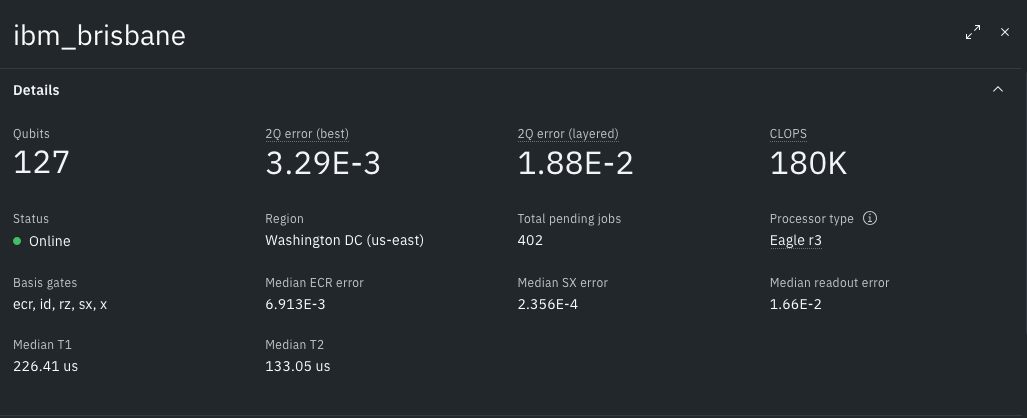

플랫폼에서뿐만 아니라 이 정보를 코드로 직접 액세스하여 확인하는 것도 가능합니다.

어떻게 할 수 있는지 함께 알아봅시다!

<a id="exercise_1"></a>
<div class="alert alert-block alert-success">
    
<b>연습문제 1: 좋은 큐빗 찾기</b> 

**목표:** T1, T2, 게이트 충실도가 높고 측정 오류는 낮은 큐빗을 찾아보세요

첫 번째 연습문제에서는 주어진 각 지표의 최댓값과, 그 값을 갖는 큐비트(또는 큐비트 쌍)를 찾아주시면 됩니다.

- 이완 시간: T1
- 위상 어긋남 시간: T2
- 측정 오류
- 단일 큐빗 게이트 오류: 'PauliX' 오류
- 이중 큐빗 게이트 오류: 'Ecr' 오류

함수를 다양하게 활용할 수 있도록 백엔드에 상관없이 작동하는 코드를 작성해주세요.

<i>참고 1: ECR 게이트는 `ibm_brisbane` 백엔드에서 사용하는 이중 큐빗 게이트이며, 다른 디바이스에서는 CZ 게이트나 CNOT 게이트를 사용할 수 있습니다. 백엔드에서 사용하는 기본 게이트 종류를 확인하려면 [backend.basis_gates](/docs/api/qiskit-ibm-runtime/ibm-backend) 속성을 확인해보세요.</i>

<i>참고 2: 같은 디바이스에서도 좋은 큐비트의 번호와 성능값은 계속해서 달라질 수 있습니다. 좋은 큐비트를 찾을 때에는 파이썬의 `min()` 함수와 `max()` 함수를 사용하여 전체 큐빗 중 최적의 큐빗을 자동으로 찾을 수 있도록 코드를 작성해주세요.</i>

</div>

아래의 코드는 `ibm_brisbane` 백엔드에서 각각의 성능 지표를 불러와 배열로 저장하는 코드입니다. 이 코드를 참고하여 연습문제를 풀어주세요.

In [5]:
# 이 셀을 실행하여 속성값의 배열을 만듭니다
service = QiskitRuntimeService(channel="ibm_quantum_platform")
# 정보를 확인할 백엔드를 지정합니다
brisbane_backend = service.backend("ibm_brisbane")
# 시스템 속성과 큐비트의 개수, 연결도(coupling map)를 불러옵니다
properties = brisbane_backend.properties()
num_qubits = brisbane_backend.num_qubits
coupling_map = brisbane_backend.coupling_map

# 백엔드의 모든 큐빗의 성능 지표를 읽어 배열로 만듭니다
t1, t2, gate_error_x, readout_error, gate_error_ecr = [], [], [], [], []
for i in range(num_qubits):
    t1.append(properties.t1(i))
    t2.append(properties.t2(i))
    gate_error_x.append(properties.gate_error(gate="x", qubits=i))
    readout_error.append(properties.readout_error(i))
for pair in coupling_map:
    gate_error_ecr.append(properties.gate_error(gate="ecr", qubits=pair))

In [6]:
def find_best_metrics(backend: QiskitRuntimeService.backend) -> list[tuple[int or list, float]]:
    """다양한 하드웨어 성능 지표를 확인해 가장 좋은 큐비트와 큐빗 쌍을 찾습니다"""
    # --- 아래에 코드를 작성해주세요 ---
    # 목표: 각각의 성능 지표에서 최선의 값과 해당하는 큐비트의 번호 얻기:
    # 슈발 그레이더는 페이크 백엔드 데이터 쓴단다
    properties = backend.properties()
    num_qubits = backend.num_qubits
    coupling_map = backend.coupling_map

    t1, t2, gate_error_x, readout_error, gate_error_ecr = [], [], [], [], []
    for i in range(num_qubits):
        t1.append(properties.t1(i))
        t2.append(properties.t2(i))
        gate_error_x.append(properties.gate_error(gate="x", qubits=i))
        readout_error.append(properties.readout_error(i))
    for pair in coupling_map:
        gate_error_ecr.append(properties.gate_error(gate="ecr", qubits=pair))

    # T1 시간이 가장 긴 큐비트와 (index_t1_max) 그 값을 (max_t1) 찾으세요
    index_t1_max = t1.index(max(t1))
    max_t1 = max(t1)

    # T2 시간이 가장 긴 큐비트와 (index_t2_max) 그 값을 (max_t2) 찾으세요
    index_t2_max = t2.index(max(t2))
    max_t2 = max(t2)

    # X 게이트 오류가 가장 작은 큐비트와 (index_min_x_error) 그 값을 (min_x_error) 찾으세요
    index_min_x_error = gate_error_x.index(min(gate_error_x))
    min_x_error = min(gate_error_x)

    # 측정 오류가 가장 작은 큐비트와 (index_min_readout) 그 값을 (min_readout) 찾으세요
    index_min_readout = readout_error.index(min(readout_error))
    min_readout = min(readout_error)

    # ECR 게이트 오류가 가장 작은 큐빗 쌍과 (min_ecr_pair) 그 값을 (min_ecr_error) 찾으세요
    
    min_ecr_pair = list(coupling_map)[gate_error_ecr.index(min(gate_error_ecr))]
    min_ecr_error = min(gate_error_ecr)
    
    # --- 코드 작성이 완료되었습니다 ---

    solutions = [
        [int(index_t1_max), max_t1],
        [int(index_t2_max), max_t2],
        [int(index_min_x_error), min_x_error],
        [int(index_min_readout), min_readout],
        [list(min_ecr_pair), min_ecr_error],
    ]
    return solutions

In [7]:
# 아래의 함수를 실행해 답안을 제출해주세요
grade_lab2_ex1(find_best_metrics)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


잘하셨습니다! 여러분은 디바이스의 속성에 액세스하고 그 중 원하는 특성을 찾는 법을 배우셨습니다. 여기까지 보셨을 때 몇 분은 왜 단순히 가장 좋은 지표 하나에 의거해 가장 좋은 큐비트를 찾지 않는지 궁금하실 수도 있을 것 같습니다. 글쎄요, 그것이 쉽지만은 않습니다.

방금 만드신 함수로 선택된 큐비트들을 직접 확인해보시면, 이 큐비트들이 서로 같지도 않고 디바이스 어느 한 쪽에 몰려있지도 않은 것을 보게 되실 것입니다. 오히려 디바이스의 여기저기에 퍼져 있을 확률이 더 높겠네요. 이것은 양자 디바이스의 문제점 중 하나를 보여줍니다: 이완 시간이 긴 큐비트는 보통 단일 큐빗 게이트 에러가 높고, 그 반대도 마찬가지입니다. 이러한 상충 관계는 하나의 지표에 의존해 큐비트를 선택해서는 주어진 양자 알고리즘에서의 최선의 결과를 보장할 수 없다는 것을 보여줍니다. 나아가서, 연결도에서 보이는 바와 같이 모든 큐비트가 서로 연결되어 있지 않다는 것도 고려해야 합니다. 이 모든 요소를 고려하여 큐비트를 고르고 배치하는 작업은 또 하나의 복잡하지만 흥미로운 도전이 됩니다. 다행히도 여러분께는 이 문제를 풀기 위해 설계된 Qiskit 툴이 있습니다: 바로 **트랜스파일러**입니다.

트랜스파일러에 대해서는 이후 섹션에서 더 자세히 다뤄보도록 하겠습니다. 우선은 흥미로운 예시 문제를 먼저 살펴볼까요?

# 2. Max-cut 문제 <a id="max-cut"></a>

최대 절단 ([Max-cut](https://en.wikipedia.org/wiki/Maximum_cut)) 문제는 [NP-hard](https://en.wikipedia.org/wiki/NP-hardnes) 분류에 속하는 그래프 문제입니다. 즉, 어떤 알고리즘도 이 문제를 다항시간 내에 풀지 못한다는 것이죠. Max-cut은 클러스터링, 네트워크, 통계물리, 머신러닝 등의 분야에 폭넓게 적용되는 최적화문제입니다. 이 문제의 목표는 그래프의 점들을 두 그룹으로 나눠 두 그룹 사이의 선분의 개수(그룹을 절단하는 선분의 개수)가 최대가 되도록 하는 것입니다. 예시 문제를 같이 확인해봅시다.

아래 그림은 점 다섯 개의 그래프에서 최대 절단을 갖도록 그룹을 분리하는 예시를 보여줍니다. 이 문제를 보는 다른 방법으로 그림에서와 같이 하나의 선을 그어서 점들을 나누고, 이 기준선이 최대한 많은 선분을 자르도록 배치하는 것으로 이해할 수도 있습니다. 그래프가 커지면 다소 상상하기 어려울 수도 있지만요.

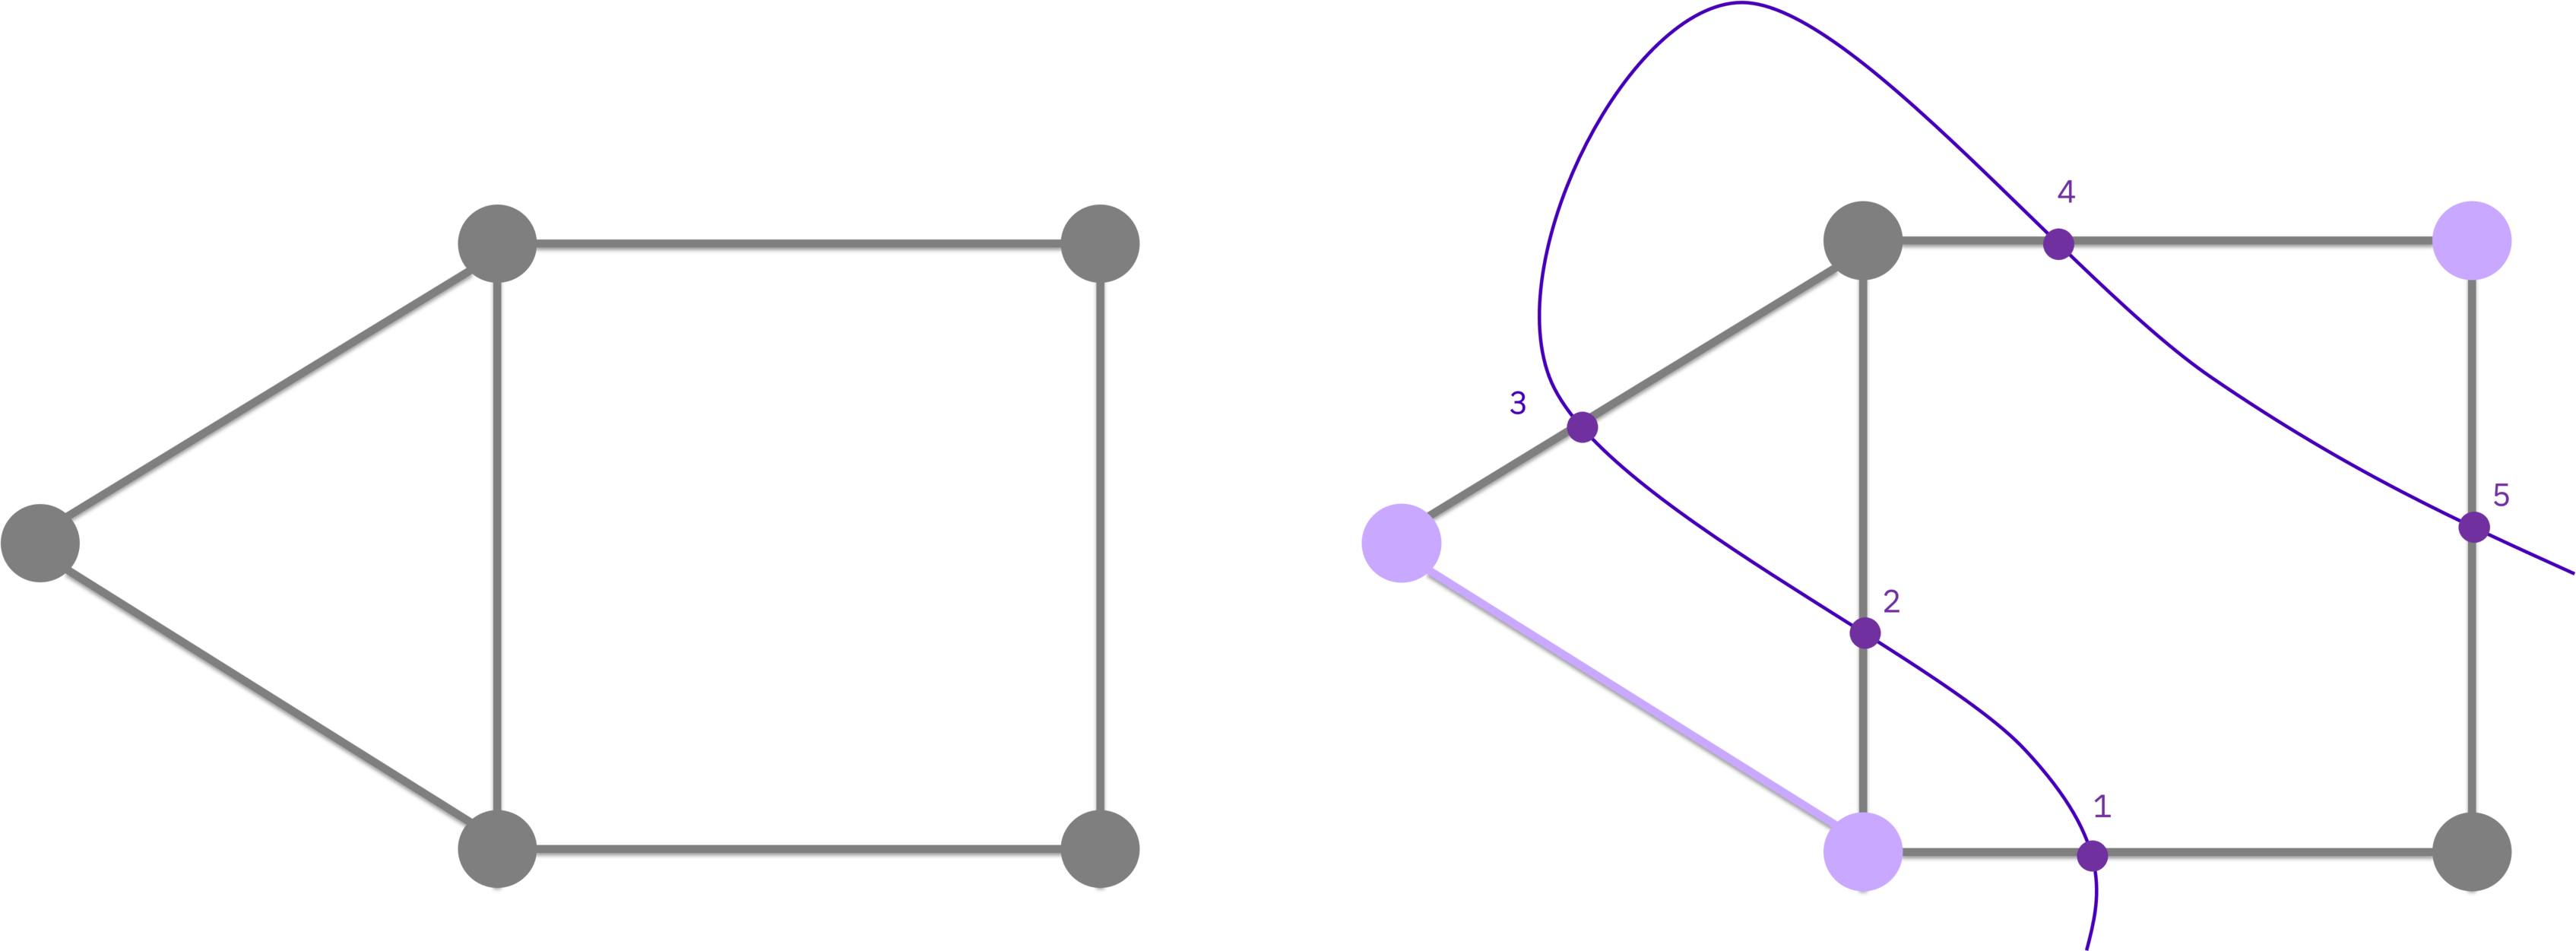

이번 랩에서는 이 Max-cut 문제를 양자 알고리즘으로 풀어보도록 하겠습니다. 또한 양자 노이즈가 이 알고리즘에 어떤 영향을 주는지 공부하고, 노이즈의 영향을 줄여 정확한 답을 얻을 수 있도록 하는 방법을 논의해보도록 하겠습니다.

## 2.1 문제: 그래프 정의하기 <a id="the-graph"></a>

Max-cut 문제에 대한 감을 잡았다면 이제 이 랩에서 풀 Max-cut 문제 그래프를 정의해봅시다. 이번에는 특히 모든 점이 서로 연결되어 있는 그래프를 고르도록 하겠습니다 $^*$.

$^*$ *문제 그래프가 완전한 대칭이 되지 않도록 그래프의 마지막 점 두 개(3, 4번)의 연결을 약간 약하게 설정하였습니다.*

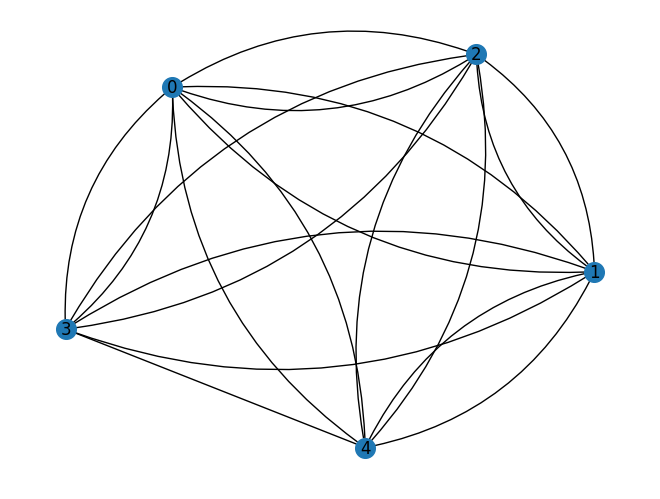

In [8]:
# 시드를 고정하여 일정한 결과를 얻을 수 있도록 합니다
seed = 43
# 그래프의 점의 개수를 정합니다
n = 5
# 그래프를 정의합니다
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
generic_backend = GenericBackendV2(n, seed=seed)
weights = 1
# 마지막 선분 하나를 제외하고 모든 점을 양방향으로 연결합니다
# 여기서는 모든 큐빗이 서로 연결되어 있는 `GenericBackend`의 연결도를 참조하여 선분을 정의합니다
graph.add_edges_from([(edge[0], edge[1], weights) for edge in generic_backend.coupling_map][:-1])
draw_graph(graph, node_size=200, with_labels=True, width=1)

## 2.2 정의: 양자컴퓨터로 그래프 옮기기 <a id="the-mapping"></a>

양자 컴퓨터에서 이 그래프 문제를 풀기 위해서는 먼저 문제를 컴퓨터가 이해할 수 있는 방식으로 바꿔줘야 합니다. 양자 컴퓨팅에서 이 문제에 접근하는 일반적이면서 강력한 방법은 최적화문제를 **해밀토니안**으로 재정의하는 것입니다. 해밀토니안이란 양자역학에서 에너지를 정의하는 수학적인 방법입니다. 이 경우, 우리 문제의 해는 이 해밀토니안의 가장 낮은 에너지 상태("바닥 상태")로 정의될 것입니다.

이러한 문제를 수식화하는 것과 관련된 개념이 두 가지 있습니다:

1.  **QUBO (Quadratic Unconstrained Binary Optimization):** QUBO는 컴퓨터 과학과 고전적인 최적화 문제에서 자주 사용되는 개념입니다. 이것은 이진 변수 **x<sub>i</sub> ∈ {0, 1}**를 조작하여 다음의 목적 함수를 최소화하는 최적화 문제입니다:

    $$ \text{minimize} \sum_{i} Q_{ii}x_{i} + \sum_{i<j} Q_{ij}x_{i}x_{j} $$

2.  **Ising Model:** 이 개념은 통계물리학에서 고전적인 방법으로 양자역학적 스핀을 다루는 단순화된 모델입니다. 이 문제에서는 스핀 **s<sub>i</sub> ∈ {+1, -1}**를 변수로 하여 다음의 에너지 해밀토니안을 최소화하는 상태를 찾습니다:

    $$ H = -\sum_{i} h_{i}s_{i} - \sum_{i<j} J_{ij}s_{i}s_{j} $$

설명에서 보이듯이 이 두 가지 개념은 서로 동등하게 다뤄질 수 있고, 다음의 변환을 통해 한 쪽에서 다른 한 쪽으로 문제를 치환하는 것도 가능합니다: **s<sub>i</sub> = 2x<sub>i</sub> - 1**.

이번 랩에서는 주어진 그래프 문제를 이 **Ising 해밀토니안**으로 대응시켜 보겠습니다. 이것은 양자 컴퓨터의 언어로도 곧바로 대응되는데, Ising 모델의 스핀 변수 **s<sub>i</sub>**를 양자 컴퓨터의 관측가능량 Z(Z축 방향 측정)의 고윳값 **+1**과 **-1**로 대응시킬 수 있기 때문입니다.

### Max-cut 문제를 Ising 해밀토니안으로 대응시키기

그래프 $G = (V, E)$ 에서 정의되는 Max-cut 문제에서, 우리는 $V$ 의 점들을 두 그룹으로 나누고자 합니다. 문제의 목표는 나눠진 두 그룹의 점들 사이를 연결하는 선분의 개수가 최대가 되도록 하는 것입니다. 이것을 스핀 변수 **s<sub>i</sub>**에 대한 함수로 나타내봅시다. 만약 연결된 두 점 `i`와 `j`가 서로 다른 그룹에 속해 있다면 (s<sub>i</sub> ≠ s<sub>j</sub> 이라면), $s_i * s_j$ 의 값은 (-1) 이 될 것입니다. 만약 두 점이 같은 그룹으로 분류된다면 (s<sub>i</sub> = s<sub>j</sub> 이라면), 두 변수를 곱한 값은 (+1) 이 됩니다.

따라서, 절단을 *최대화*하기 위해서는 모든 연결된 선분에서 $s_i * s_j$ 의 값의 합을 *최소화*하면 됩니다. 이것을 해밀토니안으로 표현하면 다음과 같습니다.

$$ H_{cost} = \sum_{(i,j) \in E} Z_i \otimes Z_j $$

여기에서는 앞의 해밀토니안과 달리 스핀 변수 `s_i`가 양자역학적 관측가능량 **Z<sub>i</sub>**로 대체되었습니다. Z<sub>i</sub>는 `i`번째 큐비트를 관측하여 `|0⟩` 상태를 관측할 경우 고윳값 (+1)을, `|1⟩` 상태를 관측할 경우 고윳값 (-1)을 돌려줄 것입니다. 이 해밀토니안의 바닥 상태는 이 에너지의 값을 최소화하는 큐비트의 상태(`|0⟩` 과 `|1⟩`)의 배열이며, 이 바닥 상태가 바로 Max-cut 문제의 해에 해당합니다.

더 자세한 내용을 알고 싶다면 다음의 [튜토리얼](https://quantum.cloud.ibm.com/docs/tutorials/quantum-approximate-optimization-algorithm)을 참고하세요.

이 내용을 잘 이해했는지가 바로 다음 연습문제에서 물어보는 내용입니다!

<a id="exercise_2"></a>
<div class="alert alert-block alert-success">
    
<b>연습문제 2: 그래프를 해밀토니안으로 대응시키기</b> 

**목표:** 앞에서 만든 'graph'를 Ising 해밀토니안으로 대응시켜 Max-cut 문제의 비용 함수를 정의해보세요.

이 두 번째 연습문제에서는 주어진 그래프 문제를 항등 연산자와 파울리 연산자를 사용해 해밀토니안으로 대응시키는 방법을 찾아주시면 되겠습니다.

</div>

<div class="alert alert-info">
<details>
    <summary> <b>힌트</b> 💡: (클릭해서 펼쳐보세요)</summary>
    이 해밀토니안을 만드는 방법은 그래프의 점 개수 n개 만큼의 힐베르트 공간(관측가능량 연산자의 길이로 나타남)을 가정한 뒤, 그래프의 선분을 불러와 선분으로 연결된 점들은 파울리 연산자 Z로, 나머지 점은 항등 연산자 I로 대응시키는 것입니다. <br> <br>
    앞에서 언급한 <a href="https://quantum.cloud.ibm.com/docs/tutorials/advanced-techniques-for-qaoa">Advanced techniques for QAOA </a> 튜토리얼의 <a href=https://quantum.cloud.ibm.com/docs/tutorials/advanced-techniques-for-qaoa#graph--hamiltonian>Graph to Hamiltonian</a> 섹션을 참고해보세요!
    
</details>
</div>

In [9]:
def graph_to_Pauli(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """그래프를 파울리 배열로 변환합니다."""
    pauli_list = []

    # --- 아래에 코드를 작성해주세요 ---
    # 목표: 그래프를 다음과 같은 리스트로 변환해주세요: [['PauliWord_1', weight_1], ['PauliWord_2', weight_2],...]
    # 큐비트의 순서와 파이썬 문자열의 순서가 서로 반대라는 점에 주의하세요
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"
 
        weight = graph.get_edge_data(edge[0], edge[1])
 
        pauli_list.append(("".join(paulis)[::-1], weight))
    # --- 코드 작성이 완료되었습니다 ---

    return pauli_list


max_cut_paulis = graph_to_Pauli(graph)
cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIIZZ', 'IIZIZ', 'IIZIZ', 'IZIIZ', 'IZIIZ', 'ZIIIZ', 'ZIIIZ', 'IIZZI', 'IIZZI', 'IZIZI', 'IZIZI', 'ZIIZI', 'ZIIZI', 'IZZII', 'IZZII', 'ZIZII', 'ZIZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j])


In [10]:
# 아래의 함수를 실행해 답안을 제출해주세요
grade_lab2_ex2(graph_to_Pauli)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


# 2.3 QAOA 알고리즘 <a id="qaoa-solution"></a>

이로써 여러분은 주어진 Max-cut 문제를 Ising 해밀토니안으로 성공적으로 정의하였으며, 고전적인 그래프 문제를 양자 바닥 상태를 찾는 문제로 변환하였습니다. 원래의 최적화 문제의 해는 이 해밀토니안의 가장 낮은 에너지 ("바닥 상태") 상태로 대응됩니다.

이처럼 해밀토니안의 바닥 상태를 찾는 문제는 굉장히 다양한 상황에서 정의될 수 있으며, 이 문제를 푸는 양자 알고리즘도 여러 가지가 논의되고 있습니다. 그 중에서도 현재 가장 일반적으로 사용되는 알고리즘은 Quantum Approximate Optimization Algorithm ([QAOA](https://en.wikipedia.org/wiki/Quantum_optimization_algorithms)) 입니다. QAOA는 다양한 최적화 문제에서 폭 넓은 적용성과 비교적 간단한 회로, 준수한 성능으로 잘 알려져 있습니다.

QAOA에 대한 더 자세한 설명을 원하신다면 다음의 [튜토리얼](https://quantum.cloud.ibm.com/docs/tutorials/quantum-approximate-optimization-algorithm) 또는 Quantum computing in practice 코스의 [Utility-scale QAOA](https://quantum.cloud.ibm.com/learning/courses/quantum-computing-in-practice/utility-scale-qaoa) 강의를 읽어보시길 추천드립니다. 여기에서는 이 알고리즘의 아이디어만 간단하게 설명드리도록 하겠습니다.

QAOA는 단열 정리(adiabatic theorem)에 기반한 변분(variational) 양자 알고리즘입니다. 단열 정리란 양자역학적 시스템의 변화가 매우 천천히 일어난다면, 처음의 바닥 상태에서 출발한 계가 변화된 바닥 상태로 넘어갈 수 있다는 정리입니다. QAOA는 이것을 모방하여, 알려진 해밀토니안(믹서)의 바닥 상태를 준비하고, 원하는 해밀토니안(목표)으로 시스템을 천천히 변화시킵니다. 이것은 두 해밀토니안을 번갈아가며 가하는 방식으로 적용되며, 각 해밀토니안을 가하는 세기를 변수로 설정하여 최적화하는 것으로 바닥 상태를 찾습니다.

짧은 이론적인 설명을 들어두고, 이제 실제로 Qiskit의 `QAOAAnsatz`를 이용해 주어진 Max-cut 문제를 푸는 QAOA 회로를 만들어봅시다.

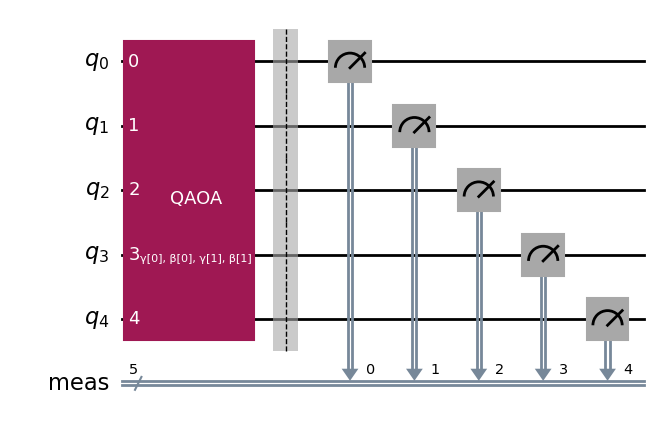

In [11]:
layers = 2
qaoa_circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=layers)
qaoa_circuit.measure_all()
qaoa_circuit.draw("mpl")

간단하죠? QAOA 회로를 정의했다면 이것을 패스매니저로 넘겨 백엔드의 기본 게이트로 트랜스파일해야 합니다.

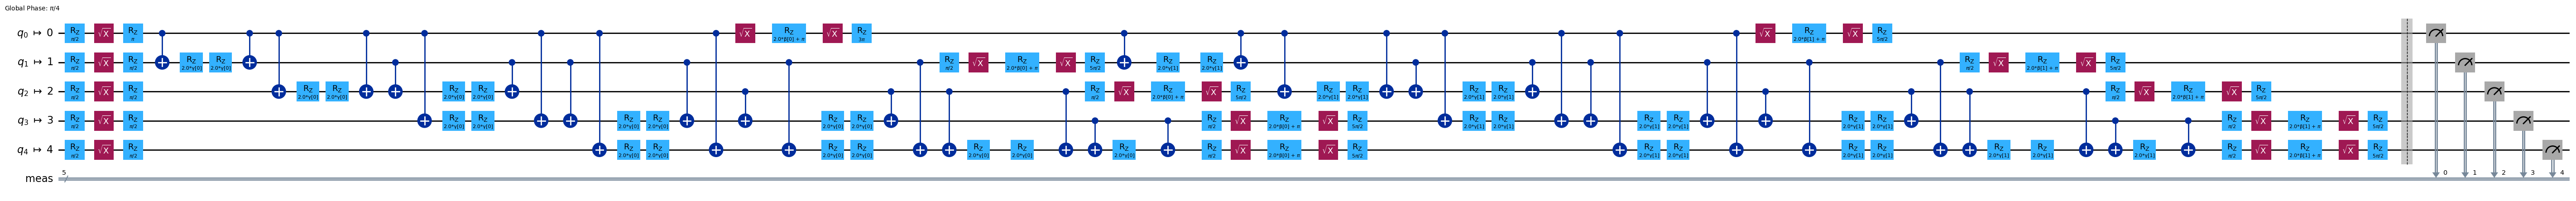

In [12]:
# 프리셋 패스매니저를 불러와 트랜스파일을 수행합니다

pm = generate_preset_pass_manager(
    optimization_level=3, backend=generic_backend, seed_transpiler=seed
)

qaoa_circuit_transpiled = pm.run(qaoa_circuit)
qaoa_circuit_transpiled.draw("mpl", fold=False, idle_wires=False)

이제 정의한 QAOA 회로의 변수의 초기값을 설정합니다.


In [13]:
init_params = np.zeros(2 * layers)

`Estimator`를 사용해 QAOA 회로에서 에너지 기댓값을 구하는 방법을 정의하고, 이것을 비용 함수로 최적화를 수행합니다. 최적화는 간단하게 `scipy` 라이브러리의 `minimize` 함수로 수행할 수 있습니다.

In [14]:
objective_func_vals = []


def cost_func_estimator(
    params: list, ansatz: QuantumCircuit, isa_hamiltonian: SparsePauliOp, estimator: Estimator
) -> float:
    """Compute the cost function value using a parameterized ansatz and an estimator for a given Hamiltonian."""
    if isa_hamiltonian.num_qubits != ansatz.num_qubits:
        isa_hamiltonian = isa_hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)
    return cost


def train_qaoa(
    params: list,
    circuit: QuantumCircuit,
    hamiltonian: SparsePauliOp,
    backend: QiskitRuntimeService.backend,
) -> tuple:
    """Optimize QAOA parameters using COBYLA and an estimator on a given backend."""
    with Session(backend=backend) as session:
        options = {"simulator": {"seed_simulator": seed}}
        estimator = Estimator(mode=session, options=options)
        estimator.options.default_shots = 100000

        result = minimize(
            cost_func_estimator,
            params,
            args=(circuit, hamiltonian, estimator),
            method="COBYLA",
            options={"maxiter": 200, "rhobeg": 1, "catol": 1e-3, "tol": 0.0001},
        )
    print(result)
    return result, objective_func_vals


result_qaoa, objective_func_vals = train_qaoa(
    init_params, qaoa_circuit_transpiled, cost_hamiltonian, generic_backend
)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -3.2863771362286376
       x: [ 9.958e-01  1.181e+00  3.710e-02  9.495e-01]
    nfev: 47
   maxcv: 0.0


최적화가 완료되면 아래의 `matplotlib` 함수로 최적화 곡선을 출력해 확인할 수 있습니다.

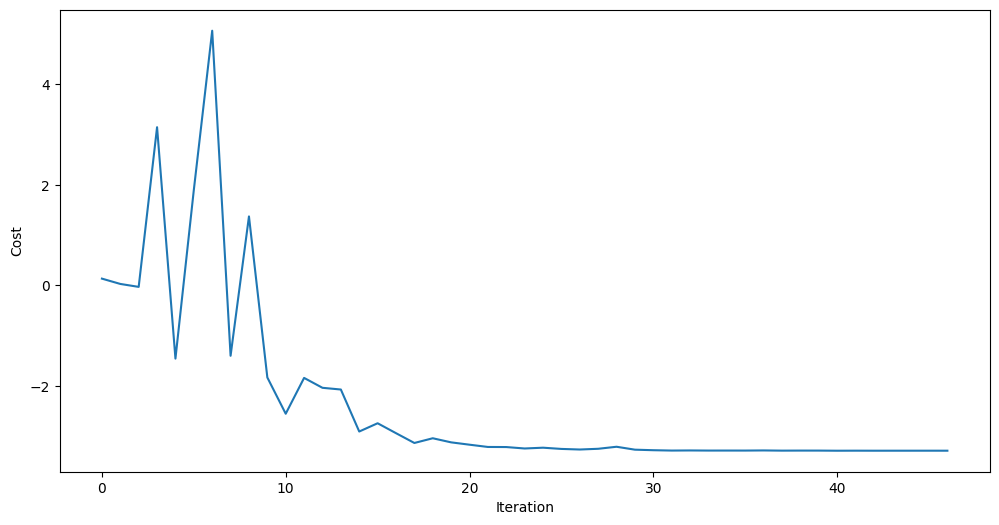

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

잘 하셨습니다! 보시다시피 QAOA 알고리즘이 꽤 잘 작동하여 비용 함수가 문제 해밀토니안의 최소 에너지 값으로 잘 수렴하였습니다. 하지만 이걸로 끝난 걸까요? 구해진 값이 정말 문제의 최소 에너지 값이 맞는지는 어떻게 알 수 있을까요? 그리고 그만큼 중요한 문제로, 찾아낸 최소 에너지 값에 대응되는 바닥 상태는 무엇일까요? 다른 말로, Max-cut 문제의 실제 해가 무엇인지는 어떻게 알 수 있을까요?

# 2.4 해 확인하기 <a id="checking"></a>

Estimator를 사용해 QAOA 회로의 해밀토니안 에너지를 최적화하였다면, 그 바닥 상태는 Sampler와 최적화가 완료된 변수값을 통해 얻을 수 있습니다.

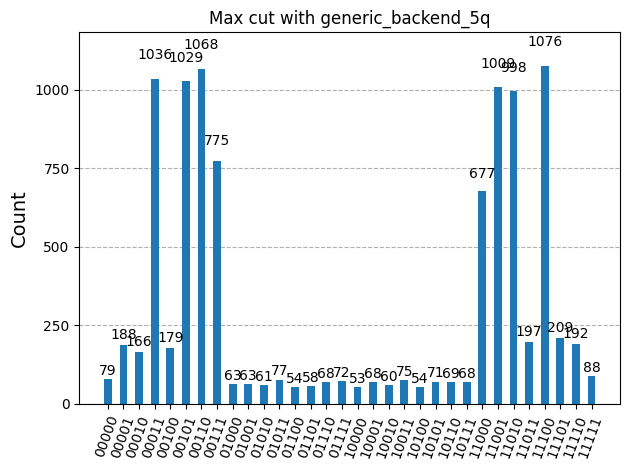

In [16]:
# 결과로부터 최적화된 변수 값을 가져옵니다
opt_params = result_qaoa.x
SHOTS = 10000


def sample_qaoa(opt_params, circuit, backend):

    # Sampler로 회로를 실행합니다
    options = {"simulator": {"seed_simulator": seed}}
    sampler = Sampler(mode=backend, options=options)
    job = sampler.run([(circuit, opt_params)], shots=SHOTS)
    results_sampler = job.result()
    counts_list = results_sampler[0].data.meas.get_counts()
    display(plot_histogram(counts_list, title=f"Max cut with {backend.name}"))

    return counts_list


counts_list = sample_qaoa(opt_params, qaoa_circuit_transpiled, generic_backend)

그래프를 확인하면 8개의 상태가 다른 상태에 비해 높은 확률로 나타나는 것으로 보입니다. 이는 8개의 바닥 상태가 존재할 수 있다는 것을 의미합니다. 하지만 그것을 어떻게 검증할 수 있을까요? 다행히도, 지금 정의한 Max-cut 문제는 그리 큰 문제가 아니어서, 고전적인 방법으로 정확한 해를 찾을 수 있습니다. 우리가 찾은 답안이 좋은 답안인지 한 번 확인해봅시다!

고전적인 방법으로 이 Max-cut 문제를 풀 때는 주어진 해밀토니안에 대각화 알고리즘을 적용하는 것으로 정확한 해를 찾을 수 있습니다. 이것은 문제가 작은 그래프에서 정의되기 때문에 가능한 방법이며, 점(큐빗)의 개수가 늘어나면 이 문제의 복잡도는 기하급수적으로 늘어나기 때문에 고전적인 방법으로는 정확한 해를 찾을 수 없게 됩니다.

In [17]:
eigenvalues, eigenvectors = np.linalg.eig(cost_hamiltonian)
ground_energy = min(eigenvalues).real
num_solutions = eigenvalues.tolist().count(ground_energy)
index_solutions = np.where(eigenvalues == ground_energy)[0].tolist()
print(f"The ground energy of the Hamiltonian is {ground_energy}")
print(f"The number of solutions of the problem is {num_solutions}")
print(f"The list of the solutions based on their index is {index_solutions}")

The ground energy of the Hamiltonian is -5.0
The number of solutions of the problem is 8
The list of the solutions based on their index is [3, 5, 6, 7, 24, 25, 26, 28]


훌륭합니다! 고전적인 방법으로 찾은 해의 개수도 8개가 나왔습니다. 이제 간단한 후처리 코드로 두 방법으로 찾은 해가 서로 일치하는지 확인해봅시다.

In [18]:
def decimal_to_binary(decimal_list, n):
    return [bin(num)[2:].zfill(n) for num in decimal_list]


# 해를 양자 상태로 변환합니다
states_solutions = decimal_to_binary(index_solutions, n)
# 샘플의 카운트가 높은 것부터 순서대로 딕셔너리를 정렬합니다
sorted_states = sorted(counts_list.items(), key=lambda item: item[1], reverse=True)
# 가장 많이 관측된 해부터 순서대로 num_solutions개의 해를 가져옵니다
top_states = sorted_states[:num_solutions]
# 두 방법으로 찾은 해를 출력하여 비교합니다
qaoa_ground_states = sorted([state for state, count in top_states])
print(f"The analytical solutions for the Max-cut problem are: {states_solutions}")
print(f"The QAOA ground states solutions for the Max-cut are: {qaoa_ground_states}")

The analytical solutions for the Max-cut problem are: ['00011', '00101', '00110', '00111', '11000', '11001', '11010', '11100']
The QAOA ground states solutions for the Max-cut are: ['00011', '00101', '00110', '00111', '11000', '11001', '11010', '11100']


야호! QAOA로 찾은 해가 최적해와 잘 일치하네요!

하지만 이제, 이 결과가 시뮬레이터를 통해 얻어졌다는 것을 기억해주세요. 실제 양자 컴퓨터에서는 노이즈와 실재적인 문제로 인해 이만큼 좋은 결과를 얻지는 못할 수도 있습니다. 다음 섹션에서는 QAOA 알고리즘을 노이즈가 있는 시뮬레이터에서 실행해보고 노이즈가 양자 알고리즘에 어떤 영향을 주는지 살펴보도록 하겠습니다.

# 3. 양자 노이즈 시뮬레이터 <a id="noisy-simulator"></a>

이번 섹션에서는 QAOA 알고리즘을 노이즈가 있는 양자 시뮬레이터에서 실행해보겠습니다. 이 시뮬레이터는 실제 양자 프로세서에서 발생하는 노이즈의 효과를 묘사할 수 있는 유용한 도구입니다. 비싼 양자 리소스를 절약하면서 알고리즘이 실제 하드웨어에서 어떻게 동작할지 미리 테스트해볼 수 있는 것이죠. 그에 더해, 노이즈 시뮬레이터는 사용자의 컴퓨터 자원만으로도 실행할 수 있기 때문에 클라우드의 양자 컴퓨터를 사용하기 위해 대기하는 시간을 절약할 수 있습니다.

자 그러면 먼저 노이즈 시뮬레이터의 기반이 될 실제 양자 컴퓨터를 선택해봅시다. 이 문제는 가끔 과소평가되기도 하지만 생각보다 중요한 문제입니다. 다음의 코드에서는 특정 양자 알고리즘을 실행하기에 가장 적합한 디바이스를 고르는 방법을 알아보도록 하겠습니다.

## 3.1 백엔드 선택 <a id="choosing-backend"></a>

이제 노이즈 시뮬레이터가 묘사할 실제 양자 컴퓨터를 선택해보겠습니다. 여러분이 사용 가능한 백엔드의 목록을 한 번 확인해볼까요?

In [19]:
real_backends = service.backends()
print(f"The quantum computers available for you are {real_backends}")

The quantum computers available for you are [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_torino')>]


만약 Open Plan(무료)을 사용하고 계시다면 현재 `ibm_brisbane`, `ibm_sherbrooke`, 그리고 `ibm_torino`가 사용 가능한 백엔드로 표시될 것입니다.

이제 각각의 사용 가능한 백엔드를 묘사하는 노이즈 시뮬레이터를 생성하고, 각 백엔드에서 사용 가능한 게이트의 목록을 확인해보겠습니다.

<div class="alert alert-block alert-warning">
<b>사용 가능한 백엔드</b>

사용하고 계신 계정에 따라서 사용 가능한 백엔드의 목록은 달라질 수 있습니다. 가능하면 ibm_brisbane, ibm_sherbrooke, 그리고 ibm_torino 3개의 백엔드만을 사용해주시되, 만약 해당 백엔드를 사용할 수 없다면 임의의 백엔드 3개를 지정해주셔도 괜찮습니다.

In [20]:
real_backends = [
    service.backend("ibm_brisbane"),
    service.backend("ibm_sherbrooke"),
    service.backend("ibm_torino"),
]

In [21]:
noisy_fake_backends = []
for backend in real_backends:
    noisy_fake_backends.append(AerSimulator.from_backend(backend, seed_simulator=seed))
print(f"The noisy simulators are {noisy_fake_backends}")

The noisy simulators are [AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['measure', 'reset', 'sx', 'ecr', 'id', 'x']>), AerSimulator('aer_simulator_from(ibm_sherbrooke)'
             noise_model=<NoiseModel on ['measure', 'reset', 'sx', 'ecr', 'id', 'x']>), AerSimulator('aer_simulator_from(ibm_torino)'
             noise_model=<NoiseModel on ['measure', 'reset', 'sx', 'id', 'x', 'cz']>)]


이제 QAOA 회로를 각각의 백엔드에 맞게 트랜스파일하고, 예상되는 오차의 크기를 미리 예측해봅시다.

다음의 연습문제에서는 앞에서 지정한 세 가지 백엔드로 트랜스파일된 양자 회로에서 발생하는 오차의 누적 예측값을 계산해볼 것입니다. 이것은 [`backend.properties()`](https://quantum.cloud.ibm.com/docs/en/guides/get-qpu-information#dynamic-backend-information), [`circuit.data`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.QuantumCircuit) 그리고 [`backend.configuration()`](https://quantum.cloud.ibm.com/docs/api/qiskit/qiskit.circuit.QuantumCircuit) 에서 양자 회로를 구성하는 양자 게이트와, 각 게이트를 수행할 때 발생하는 다양한 오차에 대한 정보를 모아 수행할 수 있습니다.

<a id="exercise_3"></a>
<div class="alert alert-block alert-success">
    
<b>연습문제 3: 오류율 예측 </b> 

**목표:** 양자 회로를 실행할 때 발생할 오차의 크기를 예측해보세요.

세 번째 연습문제에서 여러분은 각 백엔드에서 양자 회로를 실행할 때에 발생하는 오차의 크기를 예측하는 함수 `accululated_errors`를 작성해야 합니다.<br>
특히 다음의 연산에서 발생하는 오류를 고려해보세요:

- 단일 큐빗 게이트: 백엔드의 종류에 따라 'rz', 'x', 'sx' 등의 게이트가 수행되며, 각 게이트를 수행할 때에 발생하는 오차를 가져와야 합니다.
- 이중 큐빗 게이트: 백엔드의 종류에 따라 'cz', 'cx', 또는 'ecr' 게이트가 될 수 있습니다. 각 백엔드에서 어떤 게이트를 사용하는지 따로 확인이 필요합니다.
- 측정 오류: 이 오류는 회로의 마지막에 측정을 수행할 때에 누적 오차에 추가하여 계산합니다. 회로를 트랜스파일하여 선택된 큐비트를 확인하여 해당 큐비트의 측정 오류율을 가져오세요.

각 큐비트의 게이트 오류율과 측정 오류율이 모두 다르기 때문에, 단순히 IBM Quantum 플랫폼의 리소스 요약에 나타나는 평균 오류율을 곱하는 것은 안 됩니다.<br>
각 백엔드에서의 오차의 크기가 다소 비슷해보일 수도 있습니다. 다만 이 연습문제의 목표는 백엔드의 노이즈 정보와 각 큐비트의 오류 정보를 확인하고 비교하는 방법을 배우는 것이라는 점을 명심해주세요.

측정 게이트의 오차는 측정 오류율과 같으므로, 측정 게이트를 단일 큐빗 게이트로 취급하여 계산하지 마세요.

</div>

In [22]:
# 단일 큐빗 게이트, 이중 큐빗 게이트, 측정 오류의 오차를 누적하여 계산하는 함수를 정의합니다


def accumulated_errors(backend: QiskitRuntimeService.backend, circuit: QuantumCircuit) -> list:
    """주어진 백엔드에서 회로의 게이트 및 측정 오류의 누적값을 계산합니다."""

    # 값을 초기화합니다
    acc_single_qubit_error = 0
    acc_two_qubit_error = 0
    single_qubit_gate_count = 0
    two_qubit_gate_count = 0
    acc_readout_error = 0

    # 주요 변수를 정의합니다
    properties = backend.properties()
    qubit_layout = list(circuit.layout.initial_layout.get_physical_bits().keys())[:n]

    # --- 아래에 코드를 작성해주세요 ---
    # 목표: 다음의 값을 계산하는 방법을 정의하세요:
    # acc_total_error, acc_two_qubit_error, acc_single_qubit_error, acc_readout_error, single_qubit_gate_count, two_qubit_gate_count

    # TODO `properties.readout_error`에서 측정 오류율을 불러오세요 (only for qubits in qubit_layout)
    acc_readout_error=0
    for q in qubit_layout:
        acc_readout_error+= properties.readout_error(q)
    # TODO `backend.configuration()`에서 백엔드의 이중 큐빗 게이트를 확인하세요
    if "ecr" in (backend.configuration().basis_gates): 
        two_qubit_gate = "ecr"
    elif "cz" in (backend.configuration().basis_gates): 
        two_qubit_gate = "cz"
    # TODO `circuit.data`의 모든 연산에 대해 단일/이중 큐빗 게이트 개수와 오류율을 계산하세요
    # 팁: 게이트가 가해지는 큐빗의 인덱스는 Qubit._index 로 액세스해야 합니다
    for instruction in circuit.data:
        op_name = instruction.operation.name
        if(op_name in ('rz', 'sx', 'x')): # TODO 단일 큐빗 게이트의 개수와 오류율을 더하세요
            single_qubit_gate_count += 1
            qubit = instruction.qubits[0]._index
            acc_single_qubit_error += properties.gate_error(gate=op_name, qubits=[qubit])
        elif(op_name in ('cx', 'ecr', 'cz')): # TODO 이중 큐빗 게이트의 개수와 오류율을 더하세요
            two_qubit_gate_count += 1
            qubits = [q._index for q in instruction.qubits]
            acc_two_qubit_error += properties.gate_error(gate=op_name, qubits=qubits)

    # --- 코드 작성이 완료되었습니다 ---

    acc_total_error = acc_two_qubit_error + acc_single_qubit_error + acc_readout_error
    results = [
        acc_total_error,
        acc_two_qubit_error,
        acc_single_qubit_error,
        acc_readout_error,
        single_qubit_gate_count,
        two_qubit_gate_count,
    ]
    return results

이제 아래의 코드를 실행해 `errors_and_counts_list`를 얻어보고 답안을 그레이더에 제출하세요.

In [23]:
qaoa_transpiled_list = []
errors_and_counts_list = []
for noisy_fake_backend in noisy_fake_backends:
    pm = generate_preset_pass_manager(
        backend=noisy_fake_backend,
        optimization_level=3,
        seed_transpiler=seed,
    )
    circuit = pm.run(qaoa_circuit)
    qaoa_transpiled_list.append(circuit)

    errors_and_counts = accumulated_errors(noisy_fake_backend, circuit)
    errors_and_counts_list.append(errors_and_counts)
# 계산 결과가 정상적으로 출력되는지 확인해보세요
for backend, (
    acc_total_error,
    acc_two_qubit_error,
    acc_single_qubit_error,
    acc_readout_error,
    single_qubit_gate_count,
    two_qubit_gate_count,
) in zip(noisy_fake_backends, errors_and_counts_list):
    print(f"Backend {backend.name}")
    print(f"Accumulated two-qubit error of {two_qubit_gate_count} gates: {acc_two_qubit_error:.3f}")
    print(
        f"Accumulated one-qubit error of {single_qubit_gate_count} gates: {acc_single_qubit_error:.3f}"
    )
    print(f"Accumulated readout error: {acc_readout_error:.3f}")
    print(f"Accumulated total error: {acc_total_error:.3f}\n")

Backend aer_simulator_from(ibm_brisbane)
Accumulated two-qubit error of 70 gates: 0.222
Accumulated one-qubit error of 459 gates: 0.023
Accumulated readout error: 0.108
Accumulated total error: 0.353

Backend aer_simulator_from(ibm_sherbrooke)
Accumulated two-qubit error of 70 gates: 0.272
Accumulated one-qubit error of 452 gates: 0.035
Accumulated readout error: 0.066
Accumulated total error: 0.373

Backend aer_simulator_from(ibm_torino)
Accumulated two-qubit error of 70 gates: 0.187
Accumulated one-qubit error of 250 gates: 0.026
Accumulated readout error: 0.060
Accumulated total error: 0.274



결과를 그래프로 나타내봅시다.

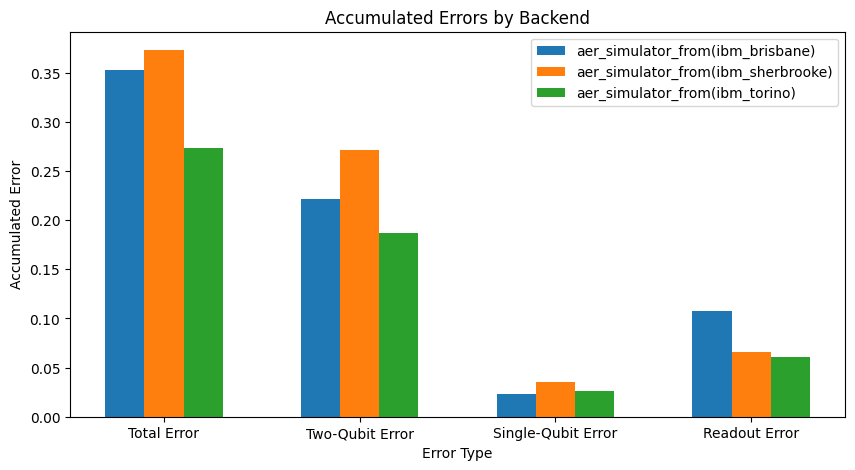

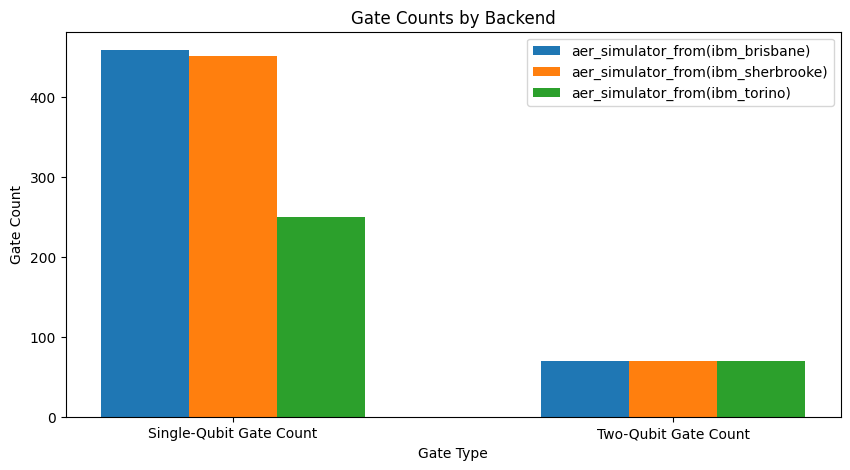

In [24]:
plot_backend_errors_and_counts(noisy_fake_backends, errors_and_counts_list)

In [25]:
# 아래의 함수를 실행해 답안을 제출해주세요
grade_lab2_ex3(accumulated_errors)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


아마 다른 백엔드에 비해 `ibm_torino`의 누적 오차가 작은 것을 확인할 수 있을 것입니다.

이제 정말 노이즈 시뮬레이터에서 QAOA 알고리즘을 실행하여 결과를 비교해봅시다!


<div class="alert alert-block alert-warning">
<b>주의: 2분 가량이 소요됩니다. 이 코드는 건너 뛰지 마세요!</b>

아래의 코드 실행에는 약 2분 가량이 소요되며, 그동안 이 노트북의 다른 코드를 실행할 수 없을 것입니다.

</div>

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -2.863381366186338
       x: [ 1.012e+00  1.237e+00  3.849e-02  9.621e-01]
    nfev: 68
   maxcv: 0.0


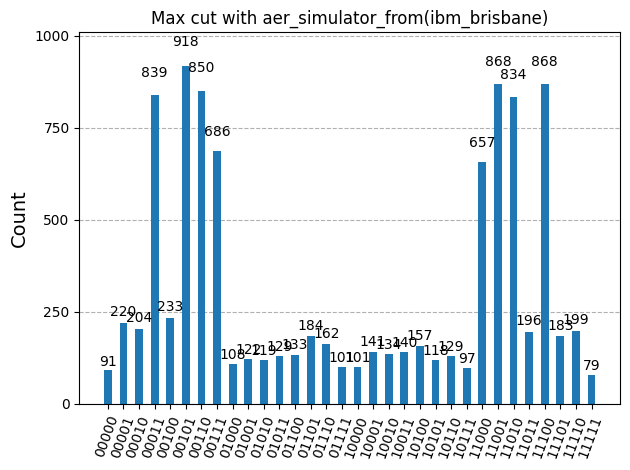

In [26]:
opt_params_list = []
counts_list_backends = []
for noisy_fake_backend, circuit in zip(noisy_fake_backends[:1], qaoa_transpiled_list[:1]):
    result_backend, _ = train_qaoa(init_params, circuit, cost_hamiltonian, noisy_fake_backend)
    opt_params = result_backend.x
    opt_params_list.append(opt_params)
    counts_list_backend = sample_qaoa(opt_params, circuit, noisy_fake_backend)
    counts_list_backends.append(counts_list_backend)

<div class="alert alert-block alert-warning">
<b>주의: 8분 가량이 소요됩니다.</b>

아래의 코드 실행에는 약 8분 가량이 소요되며, 그동안 이 노트북의 다른 코드를 실행할 수 없을 것입니다.

아래의 셀을 실행하지 않기를 원하신다면 [Section 4](#transpiler)로 바로 진행해주세요.

</div>

In [ ]:
for noisy_fake_backend, circuit in zip(noisy_fake_backends[1:], qaoa_transpiled_list[1:]):
    result_backend, _ = train_qaoa(init_params, circuit, cost_hamiltonian, noisy_fake_backend)
    opt_params = result_backend.x
    opt_params_list.append(opt_params)
    counts_list_backend = sample_qaoa(opt_params, circuit, noisy_fake_backend)
    counts_list_backends.append(counts_list_backend)

세 백엔드에서 모두 정확한 결과가 얻어지는 것으로 보입니다. 하지만 `ibm_torino` 백엔드에서는 노이즈가 비교적 적어 정답이 아닌 상태를 관측할 확률이 더 낮은 것도 확인하실 수 있습니다.

여기에서 우리는 정확한 답을 관측할 확률을 백엔드의 성능을 비교하는 지표로 삼을 수 있습니다. 세 백엔드에서 모두 8개의 정답을 가장 높은 확률로 관측하였으므로, 이러한 지표가 실질적으로 가장 신뢰할 수 있는 백엔드를 선택하는 방법이 될 수 있습니다.

In [ ]:
for noisy_fake_backend, counts_list_backend in zip(noisy_fake_backends, counts_list_backends):
    solutions_counts = [counts_list_backend[key] for key in states_solutions]
    print(
        f"Probability of measuring a solution for {noisy_fake_backend.name} is {float(sum(solutions_counts)/SHOTS)}"
    )

예상한 바와 같이, `ibm_torino`에서 정답을 관측할 확률이 가장 높은 것을 확인할 수 있습니다. 이것은 또한, 앞에서 오차의 크기를 예측한 것이 주어진 알고리즘을 최소한의 오차로 실행할 수 있는 백엔드를 찾는데에 도움이 되었다는 것을 의미합니다. 노이즈의 영향에 대해 더 논의해보기 위해, 앞에서 노이즈가 없는 시뮬레이터 `GenericBackend` 에서 관측한 정답 확률도 같이 살펴봅시다.

In [ ]:
solutions_counts_noiseless = [counts_list[key] for key in states_solutions]
print(
    f"Probability of measuring a solution for {generic_backend.name} is {float(sum(solutions_counts_noiseless)/SHOTS)}"
)

역시 예상한 바와 같이 노이즈가 없는 `GenericBackend`에서 정답을 관측할 확률이 노이즈가 있는 백엔드에서의 확률보다 높은 것을 확인할 수 있습니다. 그러나, 그 차이가 생각보다는 크지 않기도 합니다. 이 결과는 중요한 시사점을 가집니다. 현대의 노이즈가 있는 양자 컴퓨터를 가지고도, 적절한 도구를 사용하여 주의 깊게 회로를 설계한다면, 여전히 꽤 괜찮은 정확도로 여러 문제를 풀어볼 수 있다는 것입니다!

# 3.2 NEAT를 이용한 오류율 예측 <a id="neat"></a>

위에서 여러분은 디바이스의 노이즈를 꽤 근사하게 예측하였습니다. 한편 Qiskit에는 노이즈를 예측하는 또 다른 도구인 Noisy Estimator Analyzer Tool (NEAT) 를 제공하고 있습니다. NEAT는 특히 Estimator를 사용하여 기댓값을 계산하는 양자 알고리즘의 성능을 예측할 수 있도록 도와주는 함수입니다. 이 함수는 주어진 양자 회로의 이상적 (노이즈가 없는) 시뮬레이션과 노이즈 시뮬레이션을 `qiskit-aer` 시뮬레이터로 수행합니다.

NEAT의 주요 기능은 클리포드(Clifford) 회로를 이용한 효과적인 연산입니다. 일반적인 비클리포드 회로에 대해서, NEAT는 해당 회로에서 얻어지는 양자 상태를 근사하는 가장 가까운 클리포드 회로를 자동으로 찾습니다. 이것은 일반적인 시뮬레이터에서 실행 가능한 회로보다 더 큰 회로를 실행하는 경우에도 회로의 노이즈를 간단히 분석할 수 있게 해줍니다. 그러나 이러한 근사는 원래의 회로를 정확하게 묘사하는 것이 아니기 때문에, 경우에 따라 정확도가 다소 낮아질 수 있다는 한계도 있습니다.

실용적인 관점에서, NEAT를 활용해 다양한 회로에서의 노이즈의 영향을 비교하는 방법 하나는, 노이즈가 없을 때의 기댓값이 정확히 1인 관측가능량을 측정해보는 것입니다. 이 경우, 노이즈 시뮬레이션에서 측정한 기댓값이 1에서 어느 정도 벗어나는지 확인하는 것으로 노이즈의 영향을 확인할 수 있습니다. 이러한 관측가능량은 다음과 같이 간단하게 찾을 수 있습니다.
$$
\hat{O}=|\psi\rangle\langle \psi|, \quad \textrm{since} \quad \langle \psi |\hat{O}|\psi \rangle=1, 
$$
여기에서 $|\psi\rangle$ 는 시뮬레이션하는 회로의 최종 상태입니다.

앞에서와 같이 노이즈가 있는 백엔드에서 NEAT를 실행해봅시다.

In [ ]:
results = []
for backend, opt_params in zip(noisy_fake_backends, opt_params_list):
    print(f"\nRunning on backend: {backend.name}")

    # 최적화된 변수를 불러와 QAOA 회로를 정의합니다
    qaoa_neat = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=layers)
    qc = qaoa_neat.assign_parameters(opt_params)

    # 회로를 트랜스파일합니다
    qc_transpiled = generate_preset_pass_manager(
        optimization_level=3,
        basis_gates=backend.configuration().basis_gates[:n],
        seed_transpiler=seed,
    ).run(qc)
    # 회로를 클리포드화 할 때에 기존의 해밀토니안을 관측가능량으로 고려합니다
    obs = cost_hamiltonian
    analyzer = Neat(backend)
    clifford_pub = analyzer.to_clifford([(qc_transpiled, obs)])[0]

    # 클리포드 회로에서 새로운 관측가능량을 정의합니다
    state_clifford = Statevector.from_instruction(clifford_pub.circuit)
    obs_clifford = SparsePauliOp.from_operator(Operator(DensityMatrix(state_clifford).data))

    # 클리포드 회로를 다시 트랜스파일합니다
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=seed)
    isa_qc = pm.run(clifford_pub.circuit)
    isa_obs = obs_clifford.apply_layout(isa_qc.layout)

    # 시뮬레이션을 수행합니다
    pubs = [(isa_qc, isa_obs)]
    result_noiseless = (
        analyzer.ideal_sim(pubs, cliffordize=True, seed_simulator=seed)._pub_results[0].vals
    )
    noisy_results = (
        analyzer.noisy_sim(pubs, cliffordize=True, seed_simulator=seed)._pub_results[0].vals
    )

    # 결과를 저장하고 출력합니다
    results.append({"backend": backend.name, "noiseless": result_noiseless, "noisy": noisy_results})
    print(f"Ideal results on {backend.name}:\n{result_noiseless:.3f}")
    print(f"Noisy results on {backend.name}:\n{noisy_results:.3f}")

NEAT 툴을 이용하여 노이즈 시뮬레이션의 기댓값이 이론값 1에서 얼마나 벗어나는지를 확인하였습니다. 이는 [Section 3.1](#choosing-backend)에서 수행한 노이즈 분석의 결과와도 거의 일치하는 것을 확인할 수 있습니다.

그러나 앞에서 언급한 바와 같이, 여기에서는 회로를 클리포드화 하여 분석을 수행하고 있다는 점에 유의하세요. 클리포드화 된 회로는 원래 회로와 비슷하지만 일부 게이트가 클리포드 게이트로 변환되면서 다소간의 근사가 이루어지게 됩니다. 따라서, NEAT로 주어진 백엔드에서 노이즈의 영향을 예측할 수는 있지만, 예측의 정확도까지 보장되지는 않습니다. 이 점은 꼭 명심해주세요!

# 4. 트랜스파일러 <a id="transpiler"></a>

트랜스파일러는 실제 양자 하드웨어에서 양자 회로를 실행하는데 필요한 가장 중요하고 유용한 도구 중 하나입니다. 이것은 추상적이고 이론적인 버전의 양자 회로과 실제 양자 디바이스에서의 구현되는 물리적 연산 사이를 연결해주는 기능을 합니다. 여러분이 양자 회로를 설계할 때에 사용하는 큐비트와 게이트는 사실 실제 하드웨어의 특성과는 거리가 있는 가상의 큐비트 / 이상적인 게이트입니다. 하지만 트랜스파일러를 사용하면 이런 고수준의 회로를 실제 디바이스에서 사용 가능한 게이트로 변환할 수 있습니다.

예를 들어, 여러분의 회로에 가상의 큐비트 0과 1에 가해지는 CNOT 게이트가 있다고 해봅시다. 실제 디바이스에서, 이 두 큐비트는 직접적으로 연결되어 있지 않을 수도 있습니다. 그러한 경우, 트랜스파일러는 SWAP 게이트를 사용해 두 큐비트를 서로 연결된 큐비트로 옮겨 CNOT 연산을 수행할 수 있도록 합니다. 또는, 가상의 큐비트 0과 1이 대응되는 물리적 큐비트가 서로 연결되어 있는 좀 더 좋은 레이아웃을 찾을 수도 있죠 - 예를 들어, 서로 연결되어 있는 물리적 큐빗 3번과 4번을 선택하여 SWAP 게이트가 없이도 CNOT 게이트를 가할 수 있도록 할 수 있습니다.

지금까지 우리는 `generate_preset_pass_manager`로 생성되는 미리 설정된 패스매니저로 트랜스파일을 수행하였습니다. 하지만 이번에는 실제로 트랜스파일러에서 일어나는 일을 좀 더 자세히 이해해보고, 효과적인 회로 설계에 대해 생각해봅시다.

# 4.1 이중 큐빗 게이트의 수 최소화하기 <a id="min-two-qubit"></a>

양자 트랜스파일러가 수행하는 가장 중요한 작업 중 하나는 양자 회로를 실행할 큐비트의 레이아웃을 찾는 일입니다. 이것은 회로에 존재하는 가상의 큐비트를 디바이스의 물리적 큐비트로 대응시키는 최선의 방법을 찾는 것을 포함합니다. 그렇게 하기 위해서, 몇 가지 고려해야 할 사항들이 있습니다.

첫 번째로, 트랜스파일러는 회로에 존재하는 모든 이중 큐빗 게이트를 확인하여 선택된 물리적 큐비트에서 해당 연산을 수행할 수 있도록 해야 하며, 이를 위해 필요한 SWAP 게이트의 수를 최소화해야 합니다. 이를 위해 디바이스의 물리적 큐비트가 어떻게 연결되어 있는지 나타내는 연결도(coupling map)를 확인할 필요가 있습니다.

우리는 먼저 주어진 양자 회로를 양자 컴퓨터의 물리적 레이아웃에 대응시키며, 이중 큐빗 게이트의 수를 최소화하는 작업을 수행할 것입니다. 이는 이중 큐빗 게이트가 비교적 많은 오류를 발생시키기 때문입니다.

이 작업은 `ibm_brisbane` 백엔드를 기준으로 수행해봅시다. 이 백엔드에서는 [Section 3.1](#choosing-backend)에서 보았듯 전체 누적 오류의 대부분이 이중 큐빗 게이트에서 발생합니다.

In [27]:
# `ibm_brisbane` 백엔드를 선택합니다
num_backend = 0
noisy_fake_backend = noisy_fake_backends[num_backend]

pm = generate_preset_pass_manager(
    backend=noisy_fake_backend,
    optimization_level=3,
    seed_transpiler=seed,
    layout_method="sabre",
)
circuit_transpiled = pm.run(qaoa_circuit)


def two_qubit_gate_errors_per_circuit_layout(
    circuit: QuantumCircuit, backend: QiskitRuntimeService.backend
) -> tuple:
    """주어진 회로 레이아웃에서 누적 이중 큐빗 게이트 오류와 관련 지표를 계산합니다."""
    pair_list = []
    error_pair_list = []
    error_acc_pair_list = []
    two_qubit_gate_count = 0
    properties = backend.properties()
    if "ecr" in (backend.configuration().basis_gates):
        two_qubit_gate = "ecr"
    elif "cz" in (backend.configuration().basis_gates):
        two_qubit_gate = "cz"
    for instruction in circuit.data:
        if instruction.operation.num_qubits == 2:
            two_qubit_gate_count += 1
            pair = [instruction.qubits[0]._index, instruction.qubits[1]._index]
            error_pair = properties.gate_error(gate=two_qubit_gate, qubits=pair)
            if pair not in (pair_list):
                pair_list.append(pair)
                error_pair_list.append(error_pair)
                error_acc_pair_list.append(error_pair)
            else:
                pos = pair_list.index(pair)
                error_acc_pair_list[pos] += error_pair

    acc_two_qubit_error = sum(error_acc_pair_list)
    return (
        acc_two_qubit_error,
        two_qubit_gate_count,
        pair_list,
        error_pair_list,
        error_acc_pair_list,
    )


(
    acc_two_qubit_error,
    two_qubit_gate_count,
    pair_list,
    error_pair_list,
    error_acc_pair_list,
) = two_qubit_gate_errors_per_circuit_layout(circuit_transpiled, noisy_fake_backend)
two_qubit_ops_list = [int(a / b) for a, b in zip(error_acc_pair_list, error_pair_list)]
# 결과를 출력합니다
print(f"The pairs of qubits that need to perform two-qubit operations are:\n {pair_list}")
print(
    f"The errors introduced by each of the two-qubit operations are:\n {[round(err,3) for err in error_pair_list]}"
)
print(
    f"The accumulated errors introduced by each of the two-qubit operations are:\n {[round(err,3) for err in error_acc_pair_list]}"
)
print(f"The repetitions of each one of the two-qubit operations is:\n {two_qubit_ops_list}")
print(f"The number of two-qubit operations in total:\n {two_qubit_gate_count}")
print(f"The total accumulated error by two-qubit operations is:\n {acc_two_qubit_error:.3f}")

The pairs of qubits that need to perform two-qubit operations are:
 [[62, 72], [81, 72], [62, 61], [62, 63]]
The errors introduced by each of the two-qubit operations are:
 [0.009, 0.005, 0.014, 0.007]
The accumulated errors introduced by each of the two-qubit operations are:
 [0.275, 0.06, 0.18, 0.107]
The repetitions of each one of the two-qubit operations is:
 [29, 13, 13, 15]
The number of two-qubit operations in total:
 70
The total accumulated error by two-qubit operations is:
 0.622


# 4.2 최적의 레이아웃 찾기 <a id="opt-layout"></a>

다음으로, 트랜스파일러는 주어진 연결성 조건을 만족하는 "최선의" 물리적 큐비트들을 선택해야 합니다. 그러나 앞에서도 언급한 바와 같이, 이런 상황에서 무엇이 "최선"인지 정의하는 것은 다소 복잡한 문제입니다. 하드웨어마다 다른 결맞음 시간 ($T_1$, $T_2$), 단일 큐빗 게이트 오류, 측정 오류, 이중 큐빗 게이트 오류를 모두 고려해야 하기 때문입니다. 이 모든 지표를 동시에 최적화하는 것은 다소 어려운 문제이며, 종종 서로 상충하는 상황도 발생합니다.

이 연습문제에서는 문제를 단순화하기 위해 두 가지 기준에 초점을 맞추겠습니다:
1. 주어진 연결 조건을 만족하는 큐비트를 선택한다.
2. 이중 큐빗 게이트 오류가 가장 작은 큐비트들을 선택한다.

[Section 3.1](#choosing-backend)에서 보았듯 이중 큐빗 게이트 오류는 대부분의 양자 디바이스에서 오류의 지배적인 원인이 됩니다.

이중 큐빗 게이트의 오류만을 고려해 다양한 큐비트 레이아웃 중 누적 오류가 가장 작은 것을 찾아보세요.

아래의 코드를 실행하여 큐비트의 연결도를 출력해보세요. 이는 큐비트가 어떻게 연결되어 있는지를 보고 원하는 조건을 만족하는 레이아웃을 찾는데에 도움을 줄 것입니다.

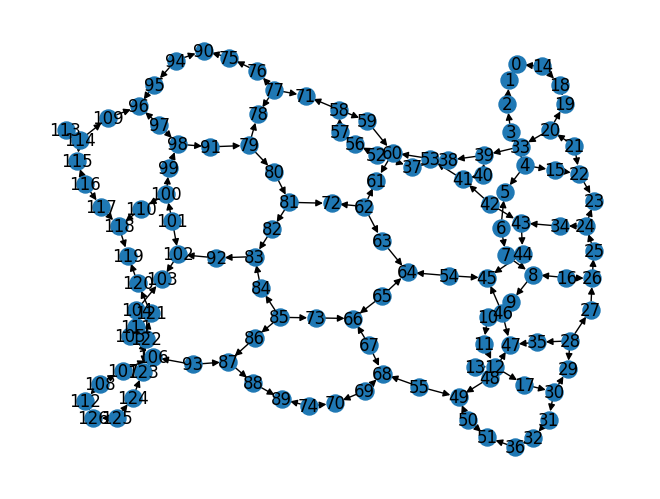

In [28]:
# 주어진 백엔드의 연결도와 오류율을 가중치 그래프로 만들고 출력합니다.
graph = rx.PyDiGraph()
graph.add_nodes_from(np.arange(0, noisy_fake_backend.num_qubits, 1))
two_qubit_gate = "ecr"
graph.add_edges_from(
    [
        (
            edge[0],
            edge[1],
            noisy_fake_backend.properties().gate_error(
                gate=two_qubit_gate, qubits=(edge[0], edge[1])
            ),
        )
        for edge in noisy_fake_backend.coupling_map
    ]
)
draw_graph(graph, node_size=150, with_labels=True, width=1)

찾아야 하는 레이아웃의 연결 조건은 앞에서 찾은 `pair_list`에서 확인할 수 있습니다. 이것은 아래에서 `logical_pair_list`로 다시 단순화하여 표현하였습니다:

In [29]:
def remap_nodes(original_labels: list, edge_list: list[list]) -> list[list[int]]:
    """큐비트의 번호를 0부터 시작하는 가상의 논리 큐비트 번호로 치환합니다"""
    label_mapping = {label: idx for idx, label in enumerate(original_labels)}
    remapped = [[label_mapping[src], label_mapping[dst]] for src, dst in edge_list]
    return remapped


layout_list = list(circuit_transpiled.layout.initial_layout.get_physical_bits().keys())[:5]
logical_pair_list = remap_nodes(layout_list, pair_list)
print(f"Physical qubit layout list:\n {layout_list}")
print(f"\nOriginal two-qubit gates list:\n {pair_list}")
print(f"\nRemapped two-qubit gates list (in logical qubits):\n {logical_pair_list}")

Physical qubit layout list:
 [72, 62, 81, 61, 63]

Original two-qubit gates list:
 [[62, 72], [81, 72], [62, 61], [62, 63]]

Remapped two-qubit gates list (in logical qubits):
 [[1, 0], [2, 0], [1, 3], [1, 4]]



<a id="exercise_4"></a>
<div class="alert alert-block alert-success">
    
<b>연습문제 4: 모든 적합한 레이아웃 찾기 </b> 

**목표:** 주어진 회로를 실행하기에 적합한 큐비트 레이아웃을 모두 찾아보세요.

네 번째 연습문제에서는 앞에서 지정된 레이아웃에서보다 낮은 이중 큐빗 게이트 오류율을 갖는 모든 큐비트 레이아웃을 찾아야 합니다. 기존의 누적 오류율은 `acc_two_qubit_error` 변수에 저장되어 있습니다. 이 문제는 위의 그래프에서 `logical_pair_list`와 같은 연결성을 가지면서 각 선분의 가중치의 누적값이 주어진 값보다 작아지도록 하는 모든 경로를 찾는 그래프 문제와 같습니다.

</div>

<div class="alert alert-block alert-warning">
<b>주의: 이 문제를 완전 탐색 알고리즘으로 풀지 마세요!</b>

이 문제를 완전 탐색 알고리즘으로 푸는 경우, 가능한 경로의 수가 너무 많아 계산에 수시간이 넘게 걸릴 수 있습니다. 대신, `logical_pair_list`에서 요구하는 연결을 갖는 경로로 탐색 범위를 한정하세요. 이 경우의 수는 100개가 채 안 되기 때문에 1초 내로 계산을 완료할 수 있습니다.

</div>

</div>

<div class="alert alert-info">
<details>
    <summary> <b>힌트</b> 💡: (클릭해서 펼쳐보세요)</summary>
    
이 연습문제의 워크플로우를 제안하자면:

1. 그래프의 각 노드에서 시작하여 한 번에 한 칸씩 경로를 확장하세요.

2. 각 단계에서 `logical_pair_list`를 참고하여 어느 노드에서 경로를 확장해야 하는지 결정하세요.

3. 확장하는 노드가 제어(control) 큐빗인지 대상(target) 큐빗인지에 따라 (`logical_pair_list`를 참고하세요) 노드를 확장하는 방법을 달리 해야 합니다:

    3.1 제어 큐빗에서 대상 큐빗으로 확장하는 경우, 유향(directed) 선분을 확인합니다 (`graph.neighbors`).

    3.2 대상 큐빗에서 제어 큐빗으로 확장하는 경우, 무향(undirected) 선분을 확인합니다 (`graph.neighbors_undirected`).

4. 각 경로를 확장하면서, 해당 선분의 가중치에 (`graph.get_edge_data(edge_1,edge_2)`) `two_qubit_ops_list`의 대응하는 값을 곱해 누적 오류율을 업데이트합니다. 무향 선분으로 확장하는 경우에는 `graph.get_edge_data(edge_2,edge_1)` 순서로 가중치를 불러와야 한다는 점을 참고하세요.

5. 경로가 완성되어 그 길이가 `two_qubit_ops_list`의 길이와 같아지면 누적 오류율이 기준값 이하인 경로만을 저장합니다.

</details>

</div>

이번 연습문제에서는 다음의 함수를 유용하게 사용할 수 있을 것입니다: [rx.PyDiGraph.neighbors](https://www.rustworkx.org/dev/apiref/rustworkx.PyDiGraph.neighbors.html), [rx.PyDiGraph.neighbors_undirected](https://www.rustworkx.org/dev/apiref/rustworkx.PyDiGraph.neighbors_undirected.html), 그리고 [rx.PyDiGraph.has_edge](https://www.rustworkx.org/apiref/rustworkx.PyDiGraph.has_edge.html) 모두 아래의 코드에서 사용되고 있습니다.

추가로, [rx.PyDiGraph.get_edge_data](https://www.rustworkx.org/apiref/rustworkx.PyDiGraph.get_edge_data.html) 함수가 특히 유용하게 사용될 수 있습니다. 이것은 그래프의 각 선분에 대응하는 이중 큐빗 게이트 오류를 얻을 수 있게 해줍니다.

In [30]:
def find_paths_with_weight_sum_below_threshold(
    graph: rx.PyDiGraph,
    threshold: float,
    two_qubit_ops_list: list[int],
    logical_pair_list: list[list[int]],
) -> tuple[list[list[int]], list[float]]:
    """그래프에서 주어진 기준값 이하의 누적 오류율을 갖는 모든 유효한 경로를 찾습니다."""
    valid_paths = []
    valid_weights = []

    # --- 연습문제 4 ---
    # 목표: 그래프에서 주어진 기준값 이하의 누적 오류율을 갖는 모든 유효한 경로를 찾아보세요.

    # 그래프에서 설정 가능한 시작점을 모두 탐색합니다
    for start_node in range(graph.num_nodes()):
        # 주어진 시작점으로 경로를 초기화합니다
        paths = [[start_node]]
        # 경로의 누적 오류율을 초기화합니다 (0부터 시작)
        weights = [0]
        # 필요한 이중 큐빗 연산을 순서대로 불러옵니다
        for i in range(len(two_qubit_ops_list)):
            new_paths = []    
            new_weights = []  
            # 현재까지 설정된 경로의 노드와 가중치를 불러옵니다
            for path, weight in zip(paths, weights):
                # 이번 연산에 참여하는 노드가 현재 경로에 포함된 노드 중 어느 것인지 확인합니다.
                # logical_pair_list를 참고하여 어느 노드에서 경로를 확장할지 결정합니다.
                if logical_pair_list[i][0] < logical_pair_list[i][1]:
                    index_of_expanding_node = logical_pair_list[i][0] # 제어 큐빗에 해당
                    node_to_expand_from = path[index_of_expanding_node]
                    # 선택된 node_to_expand_from의 모든 neighbors를 탐색합니다
                    for neighbor in graph.neighbors(node_to_expand_from):
                        # 이미 선택한 노드나 선분은 다시 고르지 않습니다
                        if neighbor not in path and graph.has_edge(node_to_expand_from, neighbor):
                            # two_qubit_ops_list에서 추가되는 게이트의 개수를 불러와 해당 선분의 가중치를 곱해 오류율을 구합니다
                            
                            #### 아래에 코드를 작성하세요 ####
                            
                            edge_weight = graph.get_edge_data(node_to_expand_from, neighbor) * two_qubit_ops_list[i]
                            
                            #### 코드 작성이 완료되었습니다 ####
                            
                            # 경로를 확장하고 가중치를 업데이트합니다
                            new_paths.append(path + [neighbor])
                            new_weights.append(weight + edge_weight)
                else:
                    index_of_expanding_node = logical_pair_list[i][1] # 대상 큐빗에 해당
                    node_to_expand_from = path[index_of_expanding_node]
                    # 선택된 node_to_expand_from의 모든 undirected_neighbors를 탐색합니다
                    for neighbor in graph.neighbors_undirected(node_to_expand_from):
                        # 이미 선택한 노드나 선분은 다시 고르지 않습니다
                        if neighbor not in path and graph.has_edge(neighbor, node_to_expand_from):
                            # two_qubit_ops_list에서 추가되는 게이트의 개수를 불러와 해당 선분의 가중치를 곱해 오류율을 구합니다
                            
                            #### 아래에 코드를 작성하세요 ####
                            
                            edge_weight = graph.get_edge_data(neighbor, node_to_expand_from) * two_qubit_ops_list[i]
                            
                            #### 코드 작성이 완료되었습니다 ####
                            
                            # 경로를 확장하고 가중치를 업데이트합니다
                            new_paths.append(path + [neighbor])
                            new_weights.append(weight + edge_weight)
            # 다음으로 진행하기 전에 경로와 가중치를 업데이트합니다
            paths = new_paths
            weights = new_weights

        # 모든 가능한 경로를 탐색한 후, 누적 오류율을 기준치와 비교합니다
        for path, weight in zip(paths, weights):

            ### 아래에 코드를 작성하세요 ###
            # if문의 조건문을 완성하세요
            if(len(path) == len(two_qubit_ops_list) + 1 and weight < threshold): 
                valid_paths.append(path)
                valid_weights.append(weight)

            ### 코드 작성이 완료되었습니다 ###
            
    # --- 연습문제 4 종료 ---

    return valid_paths, valid_weights


threshold = acc_two_qubit_error

valid_paths, valid_weights = find_paths_with_weight_sum_below_threshold(
    graph, threshold, two_qubit_ops_list, logical_pair_list
)
# 처음에 찾은 레이아웃보다 좋은 레이아웃이 없을 수도 있다는 점에 주의하세요
if valid_weights:
    minimum_weight_index = valid_weights.index(min(valid_weights))
    opt_layout = valid_paths[minimum_weight_index]
else:
    minimum_weight_index = None
    opt_layout = layout_list
print(f"We found {len(valid_paths)} valid paths")

We found 10 valid paths


In [31]:
init_layout = Layout({q: phys for q, phys in zip(qaoa_circuit.qubits, opt_layout)})
pm = generate_preset_pass_manager(
    backend=noisy_fake_backend,
    optimization_level=3,
    seed_transpiler=seed,
    initial_layout=init_layout,
    layout_method="sabre",
)

circuit_opt = pm.run(qaoa_circuit)

(
    acc_total_error_opt,
    two_qubit_gate_count,
    pair_list,
    error_pair_list,
    error_acc_pair_list,
) = two_qubit_gate_errors_per_circuit_layout(circuit_opt, noisy_fake_backend)

print(
    f"The path with smaller errors in its two-qubit gates is: {opt_layout} \n",
    f"With total accumulated error of {acc_total_error_opt:.3f}",
)

The path with smaller errors in its two-qubit gates is: [5, 4, 6, 15, 3] 
 With total accumulated error of 0.271


In [32]:
# 아래의 함수를 실행해 답안을 제출해주세요
grade_lab2_ex4(find_paths_with_weight_sum_below_threshold)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


잘 하셨습니다! 여러분은 트랜스파일에서 가장 복잡한 부분을 해내셨습니다. 이 방법으로 발견한 모든 조합은 최초의 누적 오류율보다 낮은 누적 오류율을 기록하였습니다.

여기까지 진행하시면서, 여러분은 큐비트의 레이아웃을 조정하는 것만으로도 이중 큐빗 게이트에서 발생하는 에러를 줄일 수 있다는 것을 보셨을 것입니다. 하지만 이것을 실제 하드웨어에서 양자 회로를 실행할 때마다 일일히 확인하는 것이 가능할까요? 그것은 놀라울 정도로 지루한 작업이 될 것입니다. 하지만 걱정하지 마세요 - 지금은 그저 트랜스파일러에서 수행되는 작업의 일부를 배워본 것 뿐이니까요. 트랜스파일러에서는 이처럼 주어진 회로의 연결성 조건을 만족하면서 이중 큐빗 게이트의 숫자를 최소화하는 레이아웃을 찾는 작업을 수행하고 있으며, `layout_methods`를 설정하여 그 알고리즘을 간편하게 변경할 수 있습니다.

특히 다음 연습문제에서는 확률적인 방법으로 SWAP 게이트의 개수를 최소화하는 `sabre` 매소드를 사용해보겠습니다. 트랜스파일러의 성능을 최대로 활용하기 위해, 트랜스파일러에 주는 시드의 값도 다양화해보겠습니다. 이를 통해 좀 더 다양한 레이아웃을 탐색하여 이중 큐빗 게이트 오류를 최소화하는 최선의 경우를 찾아낼 수 있을 것입니다. 이 때, 각각의 경우를 비교하는 지표가 회로의 깊이인지, 이중 큐빗 게이트의 개수인지, 측정 오류인지, 또는 다른 어떤 지표인지는 확실히 정의해두어야 할 것입니다.

<a id="exercise_5"></a>
<div class="alert alert-block alert-success">
    
<b>연습문제 5: 트랜스파일러를 사용해 최선의 레이아웃 찾기 </b> 

**목표:** 트랜스파일러를 사용하여 최선의 레이아웃을 찾아보세요.

다섯 번째 연습문제에서는 `sabre` `layout_method`를 사용하여 누적 이중 큐빗 게이트 오류율이 가장 낮은 레이아웃을 찾아보도록 하겠습니다. <br>

그렇게 하기 위하여, `seed_transpiler`의 값을 0부터 500까지 올리면서 `optimization_level=3` 으로 `generate_preset_pass_manager`를 설정하여 최선의 레이아웃을 찾아보세요. 누적 이중 큐빗 게이트 오류율은 앞에서 정의한 `two_qubit_gate_errors_per_circuit_layout` 함수로 구할 수 있다는 점을 기억하세요.

In [33]:
def finding_best_seed(
    circuit: QuantumCircuit, backend: QiskitRuntimeService.backend
) -> tuple[QuantumCircuit, int, float, int]:
    """주어진 회로와 백엔드에서 누적 이중 큐빗 게이트 오류율을 최소화하는 시드를 찾습니다."""

    # 누적 오류율을 초기화합니다
    min_err_acc_seed_loop = 100
    circuit_opt_best_seed = None
    # 500개의 시드를 주고 회로를 트랜스파일합니다
    for seed_transpiler in range(0, 500):
        pm = generate_preset_pass_manager(
            backend=backend,
            optimization_level=3,
            seed_transpiler=seed_transpiler,
            layout_method="sabre",
        )
        circuit_opt_seed = pm.run([circuit])[0]
        # --- 아래에 코드를 작성해주세요 ---
        # 목표: 주어진 시드로 회로를 트랜스파일하여 누적 오류율을 최소화하는 시드를 찾아주세요.
        # TODO `two_qubit_gate_errors_per_circuit_layout` 함수를 사용하여 트랜스파일 된 회로의 누적 오류율을 구하세요.
        err_tuple = two_qubit_gate_errors_per_circuit_layout(circuit_opt_seed,backend)
        err_acc = err_tuple[0]
        # TODO 누적 오류율이 min_err_acc_seed_loop 값보다 작은지 확인하세요. 만약 그렇다면, 새로 얻은 오류율을 저장해두세요.
        if err_acc < min_err_acc_seed_loop :
            min_err_acc_seed_loop = err_acc
            best_seed_transpiler = seed_transpiler
            two_qubit_gate_count_seed_loop = err_tuple[1]
            circuit_opt_best_seed = circuit_opt_seed
        # --- 코드 작성이 완료되었습니다 ---

    return (
        circuit_opt_best_seed,
        best_seed_transpiler,
        min_err_acc_seed_loop,
        two_qubit_gate_count_seed_loop,
    )

In [34]:
(
    circuit_opt_seed_loop,
    best_seed_transpiler,
    min_err_acc_seed_loop,
    two_qubit_gate_count_seed_loop,
) = finding_best_seed(qaoa_circuit, noisy_fake_backend)

best_layout = list(circuit_opt_seed_loop.layout.initial_layout.get_physical_bits().keys())[:n]
print(f"Best transpiler seed: {best_seed_transpiler}")
print(f"Minimum accumulated two-qubit gate error: {min_err_acc_seed_loop:.3f}")
print(f"Two-qubit gate count for best seed: {two_qubit_gate_count_seed_loop}")
print(f"Best layout (first n logical qubits mapped to physical qubits):\n {best_layout}")

Best transpiler seed: 91
Minimum accumulated two-qubit gate error: 0.239
Two-qubit gate count for best seed: 70
Best layout (first n logical qubits mapped to physical qubits):
 [15, 4, 22, 5, 3]


In [35]:
# 아래의 함수를 실행해 답안을 제출해주세요
grade_lab2_ex5(finding_best_seed)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


다음으로 트랜스파일된 QAOA 회로를 실행하여 좋은 트랜스파일의 효과를 확인해봅시다.

<div class="alert alert-block alert-warning">
<b>주의: 5분 가량이 소요됩니다.</b>


아래의 코드 실행에는 약 5분 가량이 소요되며, 그동안 이 노트북의 다른 코드를 실행할 수 없을 것입니다. 코드 실행을 원하지 않는 경우 다음으로 넘어가셔도 괜찮습니다.

</div>

In [ ]:
counts_list_transpiled_circuits = []
circuit_transpiled_list = [circuit_transpiled, circuit_opt_seed_loop]
opt_params_list_transpiled_circuits = []
for circuit in circuit_transpiled_list:
    result_backend, _ = train_qaoa(init_params, circuit, cost_hamiltonian, noisy_fake_backend)
    opt_params = result_backend.x
    opt_params_list_transpiled_circuits.append(opt_params)
    counts_list_transpiled_circuit = sample_qaoa(opt_params, circuit, noisy_fake_backend)
    counts_list_transpiled_circuits.append(counts_list_transpiled_circuits)
    solutions_counts = [counts_list_transpiled_circuit[key] for key in states_solutions]
    print(f"Probability of measuring a solution for is {float(sum(solutions_counts)/SHOTS)}")

이후에 회로를 실행할 때에도, `layout_method`를 지정하고 다양한 시드를 시도하여 노이즈 지표를 최소화하는 방법을 적용할 수 있다는 것을 기억하세요. 이러한 지표는 이중 큐빗 게이트의 개수가 될 수도 있고, 회로의 깊이나, 누적 오류율도 좋습니다.

이번 섹션에서 여러분은 양자 회로를 실제 하드웨어에서 실행할 때에 트랜스파일이 매우 중요하다는 것을 배웠습니다. 디바이스마다 다른 큐빗 레이아웃과 기본 게이트에 맞추면서도, 회로의 깊이나 오류율을 최소화해줄 수 있는 좋은 트랜스파일러가 있어야 양자 알고리즘의 성능을 최대한으로 끌어낼 수 있습니다.

# 5. 오차 완화 (Error Mitigation, EM) <a id="em"></a>

**오차 완화**는 양자 디바이스에서 필연적으로 발생하는 노이즈를 해결하는 중요한 연구 분야입니다. 오차 완화는 현재까지 제한적으로만 사용 가능한 복잡한 오류 정정 코드나 추가적인 큐비트 없이도 노이즈의 영향을 줄일 수 있는 지능적인 테크닉입니다. 오류가 발생하는 것을 직접 정정하는 대신, 오차 완화에서는 회로의 반복, 기기 조정과 조율, 고전적인 후처리와 같은 전략을 통해 최종 결과의 품질을 높이고 양자 알고리즘의 성능 향상을 꾀합니다.

이 접근법은 현대의 소형-중형의 노이즈가 심한 양자 디바이스에 특히 필요합니다. 완전한 결함 허용 양자 컴퓨터가 아니더라도, 현재 우리가 갖고 있는 디바이스의 성능을 최대로 활용하는 실질적인 방법을 바로 오차 완화 기술이 제시합니다. 오차 완화는 특히 양자 컴퓨팅과 고전 컴퓨팅을 오가는 하이브리드 알고리즘에 자연스럽게 통합될 수 있습니다:

- Variational Quantum Eigensolver (VQE),
- Quantum Approximate Optimization Algorithm (QAOA), 그리고
- Quantum-enhanced machine learning models.

주목할 만한 점은, 오차 완화가 모든 오류를 완벽히 제거해주는 것은 아니지만, 종종 충분히 유용하거나 작동 가능한 결과를 얻을 수 있도록 결과를 가공해줄 수는 있다는 것입니다. 이것은 노이즈가 낀 양자 연산의 결과와 의미 있는 결과 사이의 간극을 좁혀줌으로써, 대규모의 오류 정정 디바이스가 구현되기 전에도 실용적인 양자 어플리케이션을 가능하게 해주는 도구입니다.

여기에는 서로 다른 종류의 노이즈와 결함을 관리하는 몇 가지 잘 알려진 오류 정정 테크닉이 있습니다.

오류 정정에서 가장 널리 사용되는 방법 중 하나는 무잡음 추정법(Zero Noise Extrapolation, ZNE) 입니다. 이 방법에서는 노이즈를 의도적으로 증폭시키며 하나의 양자 회로를 반복적으로 실행하게 됩니다. 그리고는 수학적인 추정 기법을 사용하여 노이즈가 없을 때의 결과를 예측합니다. 이 방법은 [2017년 Temme et al.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.180509)에 의해 처음 도입되었습니다.

## 5.1 무잡음 추정법 (ZNE) <a id="zne"></a>

ZNE는 추가적인 큐비트나 오류 정정을 하지 않고도 양자 회로에서의 노이즈의 영향을 감소시킬 수 있는 강력한 오차 완화 기법입니다. 이 과정은 크게 노이즈 증폭, 반복 실행, 무잡음 상태에 대한 고전적인 추정의 세 단계로 나누어집니다:

### 노이즈 증폭

첫 번째 단계인 노이즈 증폭은 ZNE에서 가장 중심이 되는 단계입니다. 이를 위해서는 양자 회로를 평소보다 노이즈가 심한 환경에서 실행하되, 이 과정을 일관적이고 조작 가능한 방식으로 수행할 수 있어야 합니다. 노이즈가 증가함에 따라 결괏값이 어떻게 달라지는지 비교하는 것으로, 노이즈가 전혀 없을 때의 결과를 추정하는 것이 가능해집니다. 일반적으로 노이즈를 증폭할 때에 사용할 수 있는 방법 중 하나는 회로 접기(folding) 방법이 있습니다.

회로 접기 방법은 이론적으로 양자 회로의 결과를 바꾸지 않는 게이트를 추가적으로 수행하여 양자 컴퓨터의 노이즈를 인위적으로 증가시키는 방법입니다. 이러한 추가적인 게이트는 원래 가해야 하는 게이트의 역연산 게이트가 될 수 있습니다. 예를 들어, 유니터리 연산 $U$ 를 $ U \cdot U^\dagger \cdot U$ 로 바꾸면 이론적으로는 $U$ 연산과 동등하지만, 실제 실행에는 더 많은 시간과 게이트가 필요해지고, 따라서 하드웨어의 노이즈에 더 많이 노출될 것이라고 예측할 수 있습니다.

접기 방법에는 크게 두 가지가 있습니다: **전체적 접기** 방법과 **국소적 접기** 방법입니다.

#### 전체적 접기

전체적 접기 (global folding) 방법에서는 전체 양자 회로를 하나의 블록으로 취급하여 접기 연산을 수행합니다. 즉, 회로 전체의 유니터리 연산을 통째로 $U$ 로 정의하고, 그것의 역연산을 구해 다음과 같은 변환을 적용하는 것입니다:

$$U \rightarrow U \cdot U^\dagger \cdot U$$

이 변환은 $U^\dagger \cdot U$ 가 서로를 상쇄하기 때문에 원본 회로와 이론적으로 동일합니다. 그러나 회로가 더 길어지고 더 많은 게이트를 실행하게 되므로, 환경적인 노이즈와 하드웨어의 결함에 의한 영향을 그만큼 더 받게 됩니다.

전체적 접기 방법은 전체 회로에서의 노이즈를 빠르고 균일하게 증폭시킬 수 있다는 장점이 있습니다. 이 방법은 쉽게 구현할 수 있으며, 회로의 내부 구조에 대한 지식을 요구하지 않습니다. 이런 장점 덕분에, 전체적 접기 방법은 정교한 조작이 필요하지 않은 일반적인 상황에서 노이즈를 증폭시킬 때에 간편하게 사용할 수 있습니다.

<a id="exercise_6a"></a>

<div class="alert alert-block alert-success">
<b>연습문제 6a: 전체적 접기</b>

**목표:** 양자 회로에서 전체적 접기를 구현해보세요.

연습문제 6번의 a에서는 주어진 양자 회로에 전체적 접기를 가하는 함수를 만들어볼 것입니다. 함수를 설계할 때, 회로의 이론적 결괏값을 유지하면서 주어지는 여러 가지 노이즈 증폭 인수에 맞게 노이즈를 증폭시킬 수 있도록 해보세요. 노이즈 증폭 인수는 회로 $U$ 또는 $U^\dagger$ 가 가해지는 횟수에 대응되며, 인수가 1이면 회로를 접지 않는 상황에 해당합니다.

</div>

In [36]:
from qiskit import QuantumCircuit

def fold_global_circuit(circuit: QuantumCircuit, scale_factor: int) -> QuantumCircuit:
    """주어진 노이즈 증폭 인수에 따라 전체적 접기를 적용합니다."""
    if scale_factor % 2 == 0 or scale_factor < 1:
        raise ValueError("scale_factor must be an odd positive integer (1, 3, 5, ...)")
    # 회로를 "접는" 횟수를 정의합니다
    n_repeat = (scale_factor - 1) // 2
    folded_circuit = QuantumCircuit(circuit.qubits, circuit.clbits)

    def remove_all_measurements(qc: QuantumCircuit) -> QuantumCircuit:
        """회로의 모든 측정 연산을 제거합니다."""
        clean_qc = QuantumCircuit(qc.num_qubits)
        for instr in qc.data:
            if instr.operation.name != "measure":
                clean_qc.append(instr.operation, instr.qubits)
        return clean_qc

    # 측정을 제거하여 만든 이 양자 회로를 U (Unitary) 로 정의합니다
    clean_circuit = remove_all_measurements(circuit)

    # --- 아래에 코드를 작성해주세요 ---
    # 전체적 회로 접기를 구현해보세요. `QuantumCircuit.append`와 `QuantumCircuit.inverse` 함수를 사용하세요.
    # 회로에 U^† (inverse of clean_circuit) 와 U(clean_circuit) 를 순서대로 가하세요.

    folded_circuit = QuantumCircuit(*clean_circuit.qregs, *clean_circuit.cregs)
    folded_circuit.append(clean_circuit, clean_circuit.qubits)
    for i in range(n_repeat):
        folded_circuit.append(clean_circuit.inverse(), clean_circuit.qubits)
        folded_circuit.append(clean_circuit, clean_circuit.qubits)
    # --- 코드 작성이 완료되었습니다 ---

    return folded_circuit

In [37]:
# 아래의 함수를 실행해 답안을 제출해주세요
grade_lab2_ex6a(fold_global_circuit)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


#### 국소적 접기

국소적 접기 (local folding) 방법은 양자 회로의 특정 부분의 - 주로 오류에 취약한 게이트나 회로 일부분의 - 노이즈를 선택적으로 증폭시킬 수 있습니다. 이 방법은 전체 회로를 블록화하여 접는 대신 개별적인 양자 게이트나 회로 일부분을 접습니다. 이것은 좀 더 유연하고 특정적인 방식으로 노이즈 증폭을 수행할 수 있습니다. 여기에서 접는 대상이 되는 연산은 양자 회로의 개별적인 양자 게이트 $G$ 입니다. 국소적 접기에서는 해당 연산에 역연산을 다음과 같이 적용하여 접기를 수행합니다:

$$ G \rightarrow G \cdot G^\dagger \cdot G $$

이 변환은 이론적으로 추가된 $G^\dagger \cdot G$ 쌍이 상쇄되므로 기존의 연산과 같은 연산이 됩니다. 그러나, 실제 연산에서는 게이트 연산이 세 배 많아지게 되므로, 게이트 연산이 가해지는 큐비트에는 국소적으로 더 많은 노이즈가 끼게 됩니다. 이것은 회로에 존재하는 게이트에 각각 개별적으로 적용이 가능하므로 전체적 접기 방법보다 더 다양한 노이즈 세기를 선택적, 체계적으로 시뮬레이션 할 수 있다는 장점이 있습니다.

<a id="exercise_6b"></a>

<div class="alert alert-block alert-success">
<b>연습문제 6b: 국소적 접기</b>

**목표:** 양자 회로에서 국소적 접기를 구현해보세요.

연습문제 6번의 b에서는 양자 회로에 국소적 접기를 가하는 함수를 만들어볼 것입니다. 전체적 접기와 달리, 이 방법은 개별 게이트를 선택적으로 접어 회로의 특정 부분에서의 노이즈를 증폭시킵니다. 함수를 설계할 때, 접고자 하는 게이트를 특정하여 (예를 들어 측정 게이트는 접으면 안 됩니다) 주어진 노이즈 증폭 세기에 따라 접기를 수행할 수 있도록 해보세요.
</div>

In [56]:
def fold_local_circuit(circuit: QuantumCircuit, scale_factor: int) -> QuantumCircuit:
    """주어진 노이즈 증폭 인수에 따라 국소적 접기를 적용합니다."""

    if scale_factor % 2 == 0:
        raise ValueError("scale must be an odd positive integer (1, 3, 5, ...)")
    # 각 연산을 "접는" 횟수를 정의합니다
    n_repeat = (scale_factor - 1) // 2
    qc_folded = QuantumCircuit(circuit.qubits, circuit.clbits)

    if scale_factor == 1:
        return circuit
    else:
        for instruction in circuit.data:
        # --- 아래에 코드를 작성해주세요 ---
        # 국소적 회로 접기를 구현해보세요. 측정 게이트는 접지 마세요!
            op = instruction.operation
            q_idx = instruction.qubits
            c_idx = instruction.clbits
            if op.name != 'measure':
                for _ in range(n_repeat):
                    qc_folded.append(op.inverse(), q_idx, c_idx)
                    qc_folded.append(op, q_idx, c_idx)
                qc_folded.append(op, q_idx, c_idx)

        # --- 코드 작성이 완료되었습니다 ---

    return qc_folded

In [57]:
# 아래의 함수를 실행해 답안을 제출해주세요
grade_lab2_ex6b(fold_local_circuit)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


### 추정

접기를 통해 노이즈를 증폭시켰다면, 두 번째 단계는 양자 회로를 여러 노이즈 단계에서 반복 실행하는 것입니다. 마지막으로 세 번째 단계는, 이 결과들을 모아 선형, 다항, 또는 지수 함수 등의 고전적 피팅 방법을 적용해 노이즈가 없을 때의 결과를 **추정**하는 것입니다. 이러한 작업을 통해 ZNE는 현재의 노이즈가 있는 양자 하드웨어에서 높은 정확도의 결과를 되찾을 수 있도록 해주며, 양자 컴퓨팅 응용에 단기적으로 특히 중요한 위상을 차지합니다.

이제 QAOA 회로에 ZNE를 적용하여 노이즈가 있는 양자 하드웨어에서의 결과를 향상시켜봅시다.

In [58]:
def basic_zne(
    circuit,
    scales,
    backend,
    opt_params,
    observable,
):
    """국소적 접기를 이용한 기본 무잡음 추정법 (ZNE)."""

    exp_vals = []
    xdata = np.array(scales)
    estimator = Estimator(mode=backend)

    for scale in scales:
        # 국소적 접기를 가합니다
        folded = fold_local_circuit(circuit, scale)

        # 백엔드에 맞게 트랜스파일합니다
        basis_gates = backend.target.operation_names
        transpiled_folded = generate_preset_pass_manager(
            basis_gates=basis_gates, optimization_level=0, seed_transpiler=seed
        ).run(folded)
        pub = (
            transpiled_folded,
            observable.apply_layout(circuit.layout),
            opt_params,
        )
        # 기댓값을 구합니다
        job = estimator.run([pub])
        results = job.result()[0]
        exp_vals.append(results.data.evs)

    return xdata, exp_vals, pub

In [59]:
scales = [1, 3, 5, 7, 9, 11, 13]
xdata, ydata, pub = basic_zne(
    qaoa_circuit_transpiled,
    scales,
    noisy_fake_backend,
    opt_params_list[num_backend],
    cost_hamiltonian,
)

방금 구현한 ZNE의 결과를 검증하고 분석하기 위해 세 가지 추정 방법을 사용할 수 있습니다: 선형, 다항, 지수 추정입니다. 이 추정법을 통해 노이즈를 증폭하여 얻은 데이터로부터 노이즈가 없을 때의 회로의 결과를 예측할 수 있게 됩니다. 이것이 이루어지는 예시를 아래의 코드를 실행하여 확인해보세요:


 Extrapolation Method: LINEAR
⟨Z⟩ (ZNE Estimate): -3.468


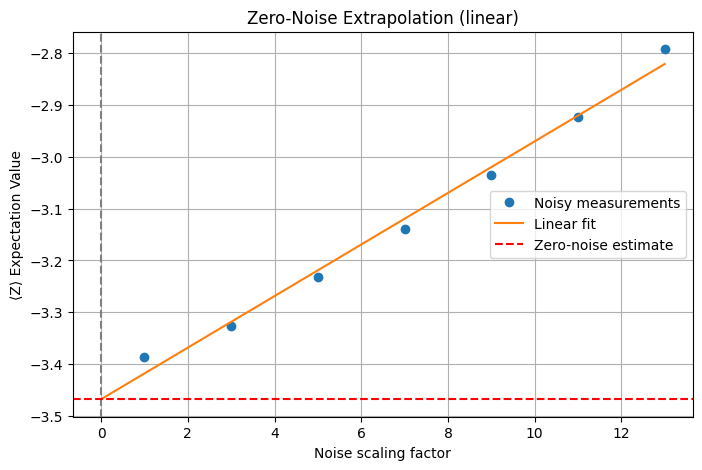


 Extrapolation Method: QUADRATIC
⟨Z⟩ (ZNE Estimate): -3.422


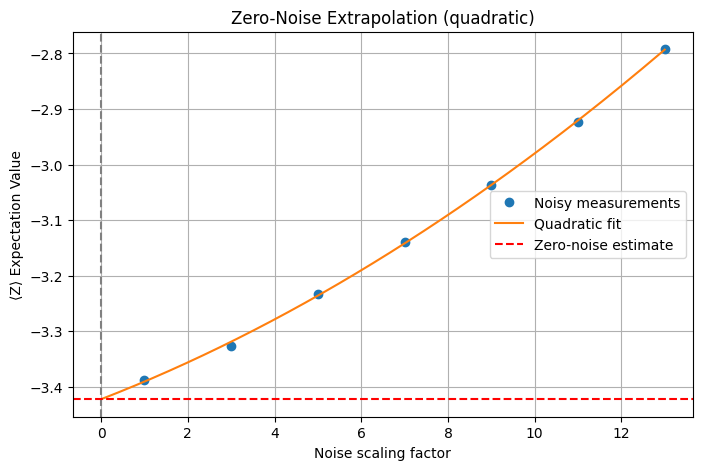


 Extrapolation Method: EXPONENTIAL
⟨Z⟩ (ZNE Estimate): -3.468


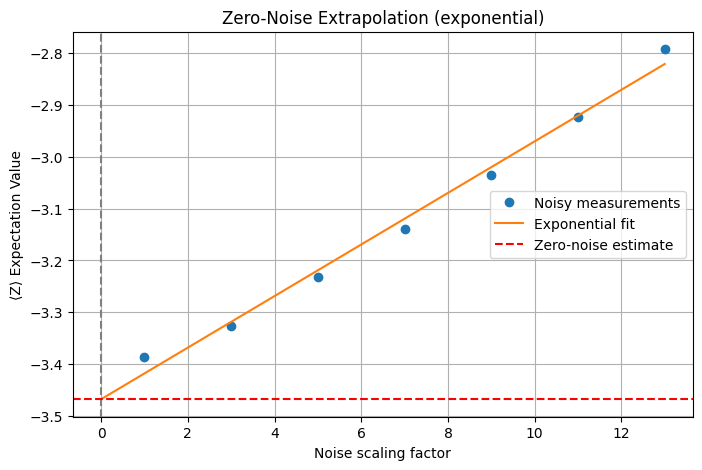

In [60]:
methods = ["linear", "quadratic", "exponential"]

for method in methods:
    print(f"\n Extrapolation Method: {method.upper()}")

    # 추정을 수행합니다
    zero_val, fitted_vals, fit_params, fit_fn = zne_method(method=method, xdata=xdata, ydata=ydata)

    # 추정된 기댓값을 출력합니다
    print(f"⟨Z⟩ (ZNE Estimate): {zero_val:.3f}")

    # 결과를 그래프로 출력합니다
    plot_zne(xdata, fitted_vals, zero_val, fit_fn, fit_params, method)

# 결론 <a id="conclusions"></a>

Lab 2를 훌륭하게 해내셨군요!

이번 랩에서는 양자회로에 영향을 줄 수 있는 다양한 노이즈의 원인과 (더 중요한 것은) 이 *노이즈를 극복하는* 도구를 알아보았습니다. 이 도구들을 얻음으로써, 여러분은 다양한 최신 양자 알고리즘들을 실제 양자 하드웨어에서 실행할 준비를 - 훌륭하게 - 마쳤습니다. 지금까지 논의한 워크플로우을 잘 기억하세요:

- **적절한 하드웨어를 골라** 회로를 실행하기.
- **트랜스파일러를 사용**하여 최선의 레이아웃을 고르고 이중 큐빗 게이트의 수와 기타 지표를 최적화하기.
- **오차 완화와 억제를 적용**하여 노이즈의 영향을 줄이고 성능을 향상시키기.

이번 랩을 해냄으로써 여러분은 앞으로의 챌린지도 훌륭하게 수행할 준비가 되었으며, 이를 자랑스럽게 여기셔도 좋습니다.

이번 챌린지는 여기까지였습니다! 잠깐, 아직인가요?

In [61]:
# 아래의 함수를 실행해 현재의 진도 상황을 확인해보세요
from qc_grader.grader.grade import check_lab_completion_status

check_lab_completion_status("qgss_2025")

Lab 0: 0/2 exercises completed (0%)
    ✅ 1740 participants have completed this lab
Lab 1: 0/9 exercises completed (0%)
    ✅ 1004 participants have completed this lab
Lab 2: 7/7 exercises completed (100%)
    ✅ 229 participants have completed this lab
Lab 3: 0/5 exercises completed (0%)
    ✅ 0 participants have completed this lab
Lab 4: 0/6 exercises completed (0%)
    ✅ 0 participants have completed this lab


# 보너스 챌린지: 더 키워보세요! <a id="bonus"></a>

보너스로 Max-cut 문제를 실제 IBM Quantum 하드웨어에서 푸는 더 복잡한 버전의 챌린지를 준비하였습니다. 이것은 지금까지 배운 것들을 실제로 사용해볼 수 있는 기회입니다. 오차 완화 테크닉을 포함해서요!

### 문제

In [ ]:
# 점의 개수를 정의합니다
n_ext = 7
# 그래프를 정의합니다
graph_ext = rx.PyGraph()
graph_ext.add_nodes_from(np.arange(0, n_ext, 1))
generic_backend_ext = GenericBackendV2(n_ext, seed=seed)
weights = 1
# 그래프의 선분 7개를 제거하여 비대칭적인 문제로 정의합니다
graph_ext.add_edges_from(
    [(edge[0], edge[1], weights) for edge in generic_backend_ext.coupling_map][:-7]
)
draw_graph(graph_ext, node_size=200, with_labels=True, width=1)
max_cut_paulis_ext = graph_to_Pauli(graph_ext)
cost_hamiltonian_ext = SparsePauliOp.from_list(max_cut_paulis_ext)
pm = generate_preset_pass_manager(
    optimization_level=3, backend=generic_backend_ext, seed_transpiler=seed
)
layers = 2
init_params = np.zeros(2 * layers)
qaoa_circuit_ext = QAOAAnsatz(cost_operator=cost_hamiltonian_ext, reps=layers)
qaoa_circuit_ext.measure_all()
qaoa_circuit_ext_transpiled = pm.run(qaoa_circuit_ext)

### 백엔드 선택하기

In [ ]:
qaoa_circuit_transpiled_ext_list = []
acc_error_list = []


for backend_hw in real_backends:

    pm = generate_preset_pass_manager(
        optimization_level=3, backend=backend_hw, seed_transpiler=seed
    )
    qaoa_circuit_transpiled_ext = pm.run([qaoa_circuit_ext])[0]
    qaoa_circuit_transpiled_ext_list.append(qaoa_circuit_transpiled_ext)

    # --- 아래에 코드를 작성해주세요 ---

    # accumulated_errors 함수에 `backend_hw`와 `qaoa_circuit_transpiled_ext`를 넣고 [0] 번째 값을 반환하세요
    acc_error = 

    # --- 코드 작성이 완료되었습니다 ---

    acc_error_list.append(acc_error)
# 오류율이 가장 낮은 하드웨어을 선택합니다
best_backend_ext = real_backends[acc_error_list.index(min(acc_error_list))]
print(
    f"The backend {best_backend_ext.name} has the circuit with the smallest accumulated error: {min(acc_error_list):.3f}"
)

### 레이아웃을 최적화하고 누적 오류율을 최소화합니다

In [ ]:
circuit_ext_opt_seed, best_seed_transpiler, min_err_acc_seed, _ = finding_best_seed(
    qaoa_circuit_ext, best_backend_ext
)
print(f"Best transpiler seed: {best_seed_transpiler}")
print(f"Minimum accumulated two-qubit gate error: {min_err_acc_seed:.3f}")

### 시뮬레이터에서 회로를 실행합니다

우선, 이 QAOA 문제의 변수를 시뮬레이터로 최적화해봅시다.

In [ ]:
best_backend_sim = AerSimulator.from_backend(best_backend_ext, seed_simulator=seed)
result_qaoa_sim, objective_func_vals_sim = train_qaoa(
    init_params, circuit_ext_opt_seed, cost_hamiltonian_ext, best_backend_sim
)

이제 QAOA 회로에서 답안 샘플을 얻을 수 있습니다.

In [ ]:
opt_params_sim = result_qaoa_sim.x
counts_list_sim = sample_qaoa(opt_params_sim, circuit_ext_opt_seed, best_backend_sim)

# 결과 확인

In [ ]:
eigenvalues_ext, eigenvectors_ext = np.linalg.eig(cost_hamiltonian_ext)
ground_energy_ext = min(eigenvalues_ext).real
num_solutions_ext = eigenvalues_ext.tolist().count(ground_energy_ext)
index_solutions_ext = np.where(eigenvalues_ext == ground_energy_ext)[0].tolist()
print(f"The ground energy of the Hamiltonian is {ground_energy_ext}")
print(f"The number of solutions of the problem is {num_solutions_ext}")
print(f"The list of the solutions based on their index is {index_solutions_ext}")

states_solutions_ext = decimal_to_binary(index_solutions_ext, n_ext)
# 샘플의 카운트가 높은 것부터 순서대로 딕셔너리를 정렬합니다
sorted_states_sim = sorted(counts_list_sim.items(), key=lambda item: item[1], reverse=True)
# 가장 많이 관측된 해부터 순서대로 num_solutions개의 해를 가져옵니다
top_states_sim = sorted_states_sim[:num_solutions_ext]
# 가져온 해를 출력합니다
qaoa_ground_states_sim = sorted([state for state, count in top_states_sim])
print(f"The analytical solutions for the Max-cut problem are: {states_solutions_ext}")
print(
    f"The QAOA ground states solutions for the Max-cut are: {qaoa_ground_states_sim} for {best_backend_sim.name}"
)

# 하드웨어에서 실행하기


<a id="Warning_1"></a>

<div class="alert alert-block alert-warning">
  <b>리소스 제한:</b> 

아래의 섹션에서는 위에서 정의한 회로를 실제 하드웨어에서 실행해볼 것입니다. 이는 양자 컴퓨터 사용량 약 2-3분 정도에 해당합니다. 양자 컴퓨터 사용에 동의하시는 경우에만 아래의 섹션을 진행해주세요. 또한, 사용량이 너무 커지지 않도록 주어진 설정값을 가능하면 변경하지 않도록 해주세요.

</div>

드디어 실제 하드웨어에서 이 알고리즘을 실행하여 결과를 확인해볼 때가 되었습니다.

### Estimator

QAOA 회로의 변수를 최적화하는 것은 실제 하드웨어에서 수행하지 않을 것입니다. 이는 특히 사용량이 제한된 Open Plan 유저분들의 양자 컴퓨터 사용시간을 아끼기 위해서입니다. 변수는 앞에서 시뮬레이터로 값을 가져오기로 하고, 대신 오류 완화 테크닉을 적용하여 결과가 어떻게 향상되는지를 확인해보도록 하겠습니다.

먼저 오류 완화를 적용하지 않고 실제 하드웨어에서 바닥 상태 에너지를 계산해봅시다.

In [ ]:
# --- 아래에 코드를 작성해주세요 ---

# 앞의 섹션을 참고하여 회로를 실행하기에 가장 적합한 백엔드를 선택해보세요
best_backend_hw = 

# --- 코드 작성이 완료되었습니다 ---

options = EstimatorOptions(default_shots=100000)
estimator = Estimator(mode=best_backend_hw, options=options)
ground_energy_ext_hw = cost_func_estimator(
    opt_params_sim, circuit_ext_opt_seed, cost_hamiltonian_ext, estimator
)
print(
    f"The ground energy of the QAOA circuit executed on {best_backend_hw.name} without EM is: {ground_energy_ext_hw}"
)

이제 오차 완화와 오류 억제 테크닉을 적용해보겠습니다. 이번에는 이것을 수동으로 수행하지 않고 QiskitRuntime의 기능을 이용해 더 많은 테크닉을 적용해봅시다:

- **Dynamical decoupling**: 이 오류 억제 테크닉은 쉬고 있는 큐비트에 게이트를 가해 주변 환경으로부터의 노이즈와 결맞음 오류를 상쇄시키는 기술입니다. 이것은 큐비트를 주변의 노이즈 원인으로부터 실질적으로 "분리"시킴으로써 양자 결맞음 상태를 유지하는 데에 도움을 줍니다.
- **Pauli twirling**: 이 오차 완화 테크닉은 연산 전후로 랜덤하게 파울리 게이트를 가하고 상쇄함으로써 복잡한 특성을 가질 수 있는 다양한 노이즈를 훨씬 단순한 파울리 노이즈로 바꿔주는 효과를 얻습니다. 이것은 결맞음 오류를 감소시키고 노이즈 모델링이나 정정 등 다른 테크닉을 더 효과적으로 적용하는 데에 도움을 줍니다.
- **TREX**: TREX란 Twirled Readout Error eXtinction의 약자로, 큐비트를 측정하기 전에 랜덤하게 큐비트를 뒤집어서 측정하는 방식으로 측정 오류를 완화합니다. 이것은 측정 오류 행렬을 대각화하는 효과도 있어, 측정 오류의 역연산을 통해 더 정확한 결괏값을 얻는 데에도 도움을 줍니다.
- **ZNE**: 앞에서 설명한 바와 같이, ZNE는 양자 계산이 노이즈가 없는 디바이스에서 실행됐을 때의 결과를 추정하는 오류 완화 테크닉입니다. 이것은 인위적으로 노이즈를 증가시켜, 결과를 측정하고, 거꾸로 노이즈가 없을 때의 결과를 추정하는 순서로 이루어집니다.

In [ ]:
options = EstimatorOptions(default_shots=100000)
# Dynamical Decoupling을 활성화합니다
options.dynamical_decoupling.enable = True

# 랜덤하게 Twirling을 수행합니다
options.twirling.enable_gates = True
options.twirling.num_randomizations = 10
options.twirling.shots_per_randomization = 10000

# TREX를 활성화합니다
options.resilience.measure_mitigation = True
options.resilience.measure_noise_learning.num_randomizations = 10
options.resilience.measure_noise_learning.shots_per_randomization = 10000

# ZNE를 설정합니다
options.resilience.zne_mitigation = True
options.resilience.zne.amplifier = "gate_folding"
options.resilience.zne.extrapolator = "polynomial_degree_2"
options.resilience.zne.noise_factors = (1, 3, 5)

# 하드웨어에서 실행합니다
estimator_EM = Estimator(mode=best_backend_hw, options=options)
ground_energy_ext_hw_EM = cost_func_estimator(
    opt_params_sim, circuit_ext_opt_seed, cost_hamiltonian_ext, estimator_EM
)
print(
    f"The ground energy of the QAOA circuit executed on {best_backend_hw.name} with EM is: {ground_energy_ext_hw_EM}"
)

같은 방법으로 실제 하드웨어에서 오류 완화를 적용하지 않고 Sampler를 실행해봅시다.

In [ ]:
opt_params_sim = result_qaoa_sim.x
# 실제 하드웨어에서 Sampler를 실행합니다
sampler = Sampler(mode=best_backend_hw)
job = sampler.run([(circuit_ext_opt_seed, opt_params_sim)], shots=SHOTS)
results_sampler = job.result()
counts_list_hw = results_sampler[0].data.meas.get_counts()
display(plot_histogram(counts_list_hw, title=f"Max cut with {best_backend_hw.name} "))

이번에는 오류 완화를 적용하여 Sampler를 실행해봅시다.

In [ ]:
opt_params_sim = result_qaoa_sim.x
# 실제 하드웨어에서 Sampler를 실행합니다
sampler = Sampler(mode=best_backend_hw)
# Sampler의 런타임 옵션을 직접 지정해줍니다
sampler.options.dynamical_decoupling.enable = True
job = sampler.run([(circuit_ext_opt_seed, opt_params_sim)], shots=SHOTS)
results_sampler = job.result()
counts_list_hw_EM = results_sampler[0].data.meas.get_counts()
display(plot_histogram(counts_list_hw_EM, title=f"Max cut with {best_backend_hw.name} with EM"))

### 결과 확인

In [ ]:
sorted_states_hw = sorted(counts_list_hw.items(), key=lambda item: item[1], reverse=True)
top_states_hw = sorted_states_hw[:num_solutions_ext]
qaoa_ground_states_hw = sorted([state for state, count in top_states_hw])

sorted_states_hw_EM = sorted(counts_list_hw_EM.items(), key=lambda item: item[1], reverse=True)
top_states_hw_EM = sorted_states_hw_EM[:num_solutions_ext]
qaoa_ground_states_hw_EM = sorted([state for state, count in top_states_hw_EM])

print(f"The analytical solutions for the Max-cut problem are: {states_solutions_ext}")
print(
    f"The QAOA ground states solutions for the Max-cut are: {qaoa_ground_states_hw} for {best_backend_hw.name}"
)
print(
    f"The QAOA ground states solutions for the Max-cut are: {qaoa_ground_states_hw_EM} for {best_backend_hw.name} with EM"
)

이번 랩을 끝까지 해낸 것을 축하드립니다!
만약 하드웨어에서 더 실험을 해보고 싶으시다면, 다음의 것들을 추가로 시도해보실 수 있습니다:

- 오류 완화 테크닉 실험해보기: 다양한 오류 완화 / 억제 전략을 적용하여 회로를 실행해보세요. 특정 기능을 껐다 켜보거나 다양한 매개변수를 조정해보며 그 효과를 확인해볼 수 있습니다.

- 다른 하드웨어에서 보너스 챌린지를 실행하기: 전체 보너스 챌린지 섹션을 다른 하드웨어에서 실행해보고 결과와 성능을 비교해보세요.

- 더 크게 키워보기: 더 큰 그래프에서 문제를 정의해보세요. 예를 들면 10개의 큐비트를 사용해 실험을 진행해볼 수 있습니다. 다만 큐비트의 숫자가 많아질수록 시뮬레이터와 하드웨어에서 회로를 실행하는데 걸리는 시간은 길어진다는 점에 주의하세요.

# References:

[1] Fahri et al., "A Quantum Approximate Optimization Algorithm" (2014). [arXiv:quant-ph/1411.4028](https://arxiv.org/abs/1411.4028)

[2] Nation et al., "Suppressing Quantum Circuit Errors Due to System Variability" (2023). [PRX Quantum 4, 010327](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.4.010327)

[3] Temme et al., "Error Mitigation for Short-Depth Quantum Circuits" (2017).  [Phys. Rev. Lett. 119, 180509](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.180509)

# Additional information

**Created by:** Jorge Martínez de Lejarza, Alberto Maldonado

**Advised by:** Marcel Pfaffhauser, Paul Nation, Junye Huang, Sophy Shin

**Translated by:** Boseong Kim

**Version:** 1.0
